# Exploratory Data Analysis on White Wine

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

from scipy import stats 
import pingouin as pg

In [6]:
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath(os.path.join('../src')) # or the path to your source code
sys.path.insert(0, module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from constants import (all_columns, all_inputs, input_param_colors)
from utils import (barplot_physicochemical_properties, get_kde_maximum, draw_points, connect_points_line)

In [8]:
# config packages
pd.options.mode.copy_on_write = "warn"

In [9]:
# load project config
with open("../config/config.yaml", "r") as file:
    config = yaml.safe_load(file)
config

{'data_path_wine_red': 'data/wine+quality/winequality-red.csv',
 'data_path_wine_white': 'data/wine+quality/winequality-white.csv'}

# Import

In [10]:
# import data
# TODO - how to build paths in python
# TODO - work with config
# TODO share variables across notebooks better?

wine_w_orig = pd.read_parquet('../data/processed/wine_w_orig.parquet')
wine_w = pd.read_parquet('../data/processed/wine_w.parquet')
wine_w_norm = pd.read_parquet('../data/processed/wine_w_norm.parquet')
wine_w_is_outlier_any = pd.read_parquet('../data/processed/wine_w_is_outlier_any.parquet')

In [11]:
wine_w.shape

(3961, 21)

In [12]:
wine_w_is_outlier_any.shape

(3961, 1)

# Outliers

In [13]:
# TODO make config file!
MIN_Q_RATING = 7

mask_w_wo_outliers = ~(((wine_w.input_outlier_count>=1) | wine_w.input_outliers_if) & (wine_w.quality<=MIN_Q_RATING))

In [14]:
remove_outliers = False

if remove_outliers:
    wine_w = wine_w[~wine_w_is_outlier_any.loc[:,0]]
    wine_w_norm = wine_w_norm[~wine_w_is_outlier_any.loc[:,0]]

In [15]:
wine_w.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3961 entries, 0 to 4897
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   ph                                   3961 non-null   float64 
 1   fixed_acidity                        3961 non-null   float64 
 2   volatile_acidity                     3961 non-null   float64 
 3   citric_acid                          3961 non-null   float64 
 4   chlorides                            3961 non-null   float64 
 5   total_sulfur_dioxide                 3961 non-null   float64 
 6   free_sulfur_dioxide                  3961 non-null   float64 
 7   sulphates                            3961 non-null   float64 
 8   residual_sugar                       3961 non-null   float64 
 9   density                              3961 non-null   float64 
 10  alcohol                              3961 non-null   float64 
 11  quality               

In [16]:
wine_w.head()

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,...,quality,color,quality_label,total_sulfur_dioxide_above_eu_limit,volatile_acid_above_eu_limit,sulfur_dioxide_ratio,acidity_ratio,total_acidity,input_outlier_count,input_outliers_if
0,3.00,7.0,0.27,0.36,0.045,170.0,45.0,0.45,20.7,1.0010,...,6,white,medium,False,False,0.264706,0.038571,7.63,0,False
1,3.30,6.3,0.30,0.34,0.049,132.0,14.0,0.49,1.6,0.9940,...,6,white,medium,False,False,0.106061,0.047619,6.94,0,False
2,3.26,8.1,0.28,0.40,0.050,97.0,30.0,0.44,6.9,0.9951,...,6,white,medium,False,False,0.309278,0.034568,8.78,0,False
3,3.19,7.2,0.23,0.32,0.058,186.0,47.0,0.40,8.5,0.9956,...,6,white,medium,False,False,0.252688,0.031944,7.75,0,False
6,3.18,6.2,0.32,0.16,0.045,136.0,30.0,0.47,7.0,0.9949,...,6,white,medium,False,False,0.220588,0.051613,6.68,0,False


# Describe

In [17]:
wine_w.describe().T

,count,mean,std,min,25%,50%,75%,max
ph,3961.0,3.195458,0.151546,2.720000,3.090000,3.180000,3.290000,3.820000
fixed_acidity,3961.0,6.839346,0.866860,3.800000,6.300000,6.800000,7.300000,14.200000
volatile_acidity,3961.0,0.280538,0.103437,0.080000,0.210000,0.260000,0.330000,1.100000
citric_acid,3961.0,0.334332,0.122446,0.000000,0.270000,0.320000,0.390000,1.660000
chlorides,3961.0,0.045905,0.023103,0.009000,0.035000,0.042000,0.050000,0.346000
total_sulfur_dioxide,3961.0,137.193512,43.129065,9.000000,106.000000,133.000000,166.000000,440.000000
free_sulfur_dioxide,3961.0,34.889169,17.210021,2.000000,23.000000,33.000000,45.000000,289.000000
sulphates,3961.0,0.490351,0.113523,0.220000,0.410000,0.480000,0.550000,1.080000
residual_sugar,3961.0,5.914819,4.861646,0.600000,1.600000,4.700000,8.900000,65.800000
density,3961.0,0.993790,0.002905,0.987110,0.991620,0.993500,0.995710,1.038980


### Primary Observations from describe
- The input accuracy is quite low, only a few digits: 
  - two digits, except for density 
- The quantities may vary quite strongly! 
  - kind of stable: ph, fixed acidity, density, alcohol
  - quantities with high variations:
    - Volatile Acidity, Citric Acid, Chlorides, Sulphates, Total Sulfur Dioxide, Free Sulfur Dioxide, Residual Sugar
    - pay attention with these quantities! error propagation

# (Linear) Correlations

Note: Don't put too much effort in this shit, since linearity is not given! Rather spend time on domain knowledge and understanding the relations between the features. Can the problem be classified somehow?

In [18]:
# TODO put in utils
def plot_corr_matrix(corr, ax=None):
    corr_plot = corr.drop(index=corr.index[0])
    if len(corr.columns)>1:
        corr_plot = corr_plot.drop(columns=corr.columns[-1])
    mask = np.triu(np.ones_like(corr_plot, dtype=bool), k=1)
    return sns.heatmap(corr_plot, mask=mask, annot=True, cmap='coolwarm', cbar=False, vmin=-1, vmax=1, square=True, ax=ax)

In [19]:
corr_w = wine_w[all_columns].corr(numeric_only=True)
corr_w

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol,quality
ph,1.000000,-0.431274,-0.046954,-0.183015,-0.090573,0.008239,-0.007750,0.142353,-0.165997,-0.063734,0.093095,0.123829
fixed_acidity,-0.431274,1.000000,-0.019214,0.298959,0.024036,0.082425,-0.058396,-0.017453,0.083620,0.266091,-0.110788,-0.124636
volatile_acidity,-0.046954,-0.019214,1.000000,-0.163228,0.086287,0.102315,-0.102471,-0.021150,0.098340,0.060603,0.046815,-0.190678
citric_acid,-0.183015,0.298959,-0.163228,1.000000,0.132590,0.122845,0.091681,0.049442,0.106269,0.160076,-0.076514,0.007065
chlorides,-0.090573,0.024036,0.086287,0.132590,1.000000,0.191145,0.101272,0.017871,0.076091,0.253088,-0.356928,-0.217739
total_sulfur_dioxide,0.008239,0.082425,0.102315,0.122845,0.191145,1.000000,0.619437,0.136544,0.409583,0.536868,-0.446643,-0.183356
free_sulfur_dioxide,-0.007750,-0.058396,-0.102471,0.091681,0.101272,0.619437,1.000000,0.037932,0.306835,0.294638,-0.251768,0.010507
sulphates,0.142353,-0.017453,-0.021150,0.049442,0.017871,0.136544,0.037932,1.000000,-0.020503,0.082048,-0.022850,0.053200
residual_sugar,-0.165997,0.083620,0.098340,0.106269,0.076091,0.409583,0.306835,-0.020503,1.000000,0.820498,-0.398167,-0.117339
density,-0.063734,0.266091,0.060603,0.160076,0.253088,0.536868,0.294638,0.082048,0.820498,1.000000,-0.760162,-0.337805


### Correlations of input quantities and quality

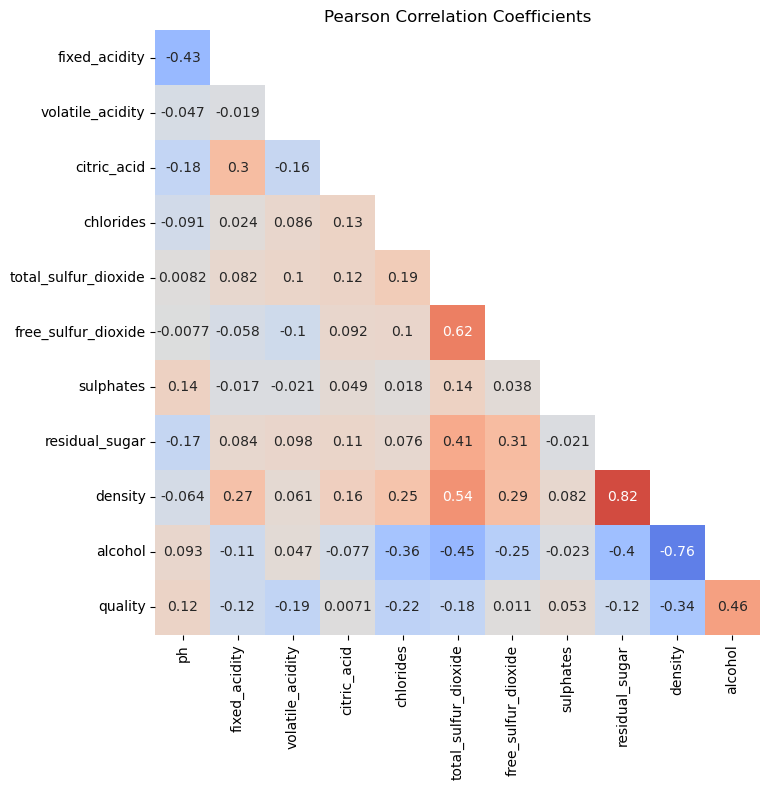

In [20]:
# plot correlation matrix for white wine
# TODO draw color bar
f, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_corr_matrix(corr_w, ax)
ax.set_title('Pearson Correlation Coefficients')
plt.tight_layout()

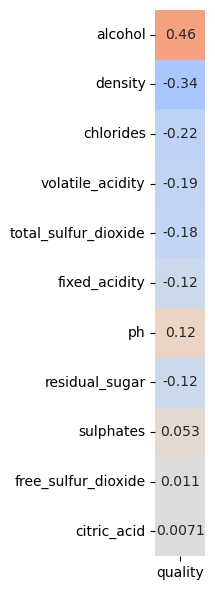

In [21]:
# top features on quality according to correlation coefficients
top_features_w = corr_w.sort_values('quality', ascending=False, key=np.abs)

# shape data frame
top_features_w = top_features_w.drop(columns=[col for col in top_features_w.columns if col not in top_features_w.index])
# top_features_w = top_features_w.loc[top_features_w.columns]

fig, ax = plt.subplots(1, 1, figsize=(10,6))
plot = plot_corr_matrix(pd.DataFrame(top_features_w['quality']), ax)
plt.tight_layout()


In [22]:
# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr_r, dtype=bool))

# # Set up the matplotlib figure
# fig, ax = plt.subplots(1, 3, figsize=(11, 9), gridspec_kw={"width_ratios":[1, 1, 0.05]})#,  sharex=True, sharey=True) # gridspec_kw={"width_ratios":[1, 1, 0.05]},
# # ax = ax.flatten()

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# cplot_wine_r = sns.heatmap(corr_r, mask=mask, 
#             cmap=cmap, vmin=-1, vmax=1, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5},
#             ax=ax[0],
#             cbar=False
#             )

# cplot_wine_w = sns.heatmap(corr_w, mask=mask, 
#             cmap=cmap, vmin=-1, vmax=1, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5},
#             ax=ax[1],
#             cbar=False
#             )

# # settings red wine plot
# ax[0].set_title('Red Wine')

# # settings white wine plot
# ax[1].set_title('White Wine')
# ax[1].set_yticks([], labels=[])
# plt.legend().remove()

# # colorbar
# # TODO - reduce height of colorbar
# mappable = cplot_wine_r.get_children()[0] # TODO - what's the artist? what does this mean?
# plt.colorbar(mappable, cax=ax[2], orientation = 'vertical')#, pad=0.2)

# # # legend
# # # Get all lines and labels from all axes
# # handles = []
# # labels = []
# # for ax in fig.axes:
# #     for h, l in zip(*ax.get_legend_handles_labels()):
# #         handles.append(h)
# #         labels.append(l)

# # # Remove any existing legends from subplots
# # for ax in fig.axes:
# #     if ax.get_legend():
# #         ax.get_legend().remove()

# # # Create figure-level legend
# # # fig.legend(handles, labels, loc='upper center', 
# # #            bbox_to_anchor=(0.5, 1.1), ncol=2)

# # fig
# fig.suptitle('Correlations', fontsize=16)

# plt.tight_layout()

Correlations are considered
- high if absolute value > 0.4
- medium if 0.2 < absolute value < 0.4
- low if absolute value < 0.2

### Observations from corr for white wines
- The input parameter correlation are low, except for 
  - the quantities that are somewhat related, e.g. pH and acidity, whereas there are exceptions!
  - fixed acidity and density
  - sulfur oxides
    - residual sugar
    - density
  - density
    - alcohol 
    - fixed acidity (pos, medium)
    - density
  - alcohol
    - density (neg, high) causal!
    - total sulfur oxide (neg, high)
    - chlorides (neg, high)
    - free sulfur oxide (neg, high)
    - residual sugar (neg, medium) causal!
- Quality correlations are
  - high
    - alcohol (positive correlation)
    - density (negative correlation), surprisingly not for residual sugar
  - medium
    - volatile acidity: negative
    - chlorides: negative
  - low
    - fixed acidity: negative
    - pH: positive
    - total sulfur dioxide: negative
    - residual sugar: negative

Questions on data set
- Density and residual sugar correlate differently with the other quantities. Why? what does that mean?
  - Density is also strongly corrlated to other quantities, both that are in the data set and outside of the data set.
- What do the correlations between the input quantities mean? 
  - Some sort of collinear, non-causal relation, i.e. it can be just in the data set.
  - Domain knowledge is needed to make sense of these relations.

### Further Considerations on Quality Correlations

In [23]:
# TODO quality is a discrete variable; how to calculate the correlation coefficient? use point biserial
# stats.pointbiserialr(wine_r['quality'], wine_r['alcohol'])

### Correlation without Outliers

In [24]:
# TODO analyse dem shit

## Correlations of Additional Features

In [25]:
cols = ['ph', 'fixed_acidity', 'volatile_acidity', 'citric_acid', 'acidity_ratio', 'total_acidity', 
        'chlorides',
        'total_sulfur_dioxide', 'free_sulfur_dioxide', 'sulfur_dioxide_ratio', 'sulphates',
        'residual_sugar', 'density',
        #'the_product', 
        'alcohol',
        'quality']
corr_w_2 = wine_w[cols].corr(numeric_only=True)
corr_w_2

,ph,fixed_acidity,volatile_acidity,citric_acid,acidity_ratio,total_acidity,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulfur_dioxide_ratio,sulphates,residual_sugar,density,alcohol,quality
ph,1.000000,-0.431274,-0.046954,-0.183015,0.101859,-0.439487,-0.090573,0.008239,-0.007750,-0.014043,0.142353,-0.165997,-0.063734,0.093095,0.123829
fixed_acidity,-0.431274,1.000000,-0.019214,0.298959,-0.336081,0.987704,0.024036,0.082425,-0.058396,-0.144634,-0.017453,0.083620,0.266091,-0.110788,-0.124636
volatile_acidity,-0.046954,-0.019214,1.000000,-0.163228,0.935346,0.073184,0.086287,0.102315,-0.102471,-0.208478,-0.021150,0.098340,0.060603,0.046815,-0.190678
citric_acid,-0.183015,0.298959,-0.163228,1.000000,-0.263092,0.399602,0.132590,0.122845,0.091681,0.013547,0.049442,0.106269,0.160076,-0.076514,0.007065
acidity_ratio,0.101859,-0.336081,0.935346,-0.263092,1.000000,-0.248494,0.057068,0.053146,-0.086896,-0.147822,-0.016830,0.047962,-0.045930,0.090450,-0.135311
total_acidity,-0.439487,0.987704,0.073184,0.399602,-0.248494,1.000000,0.050396,0.106361,-0.054777,-0.159179,-0.012340,0.104822,0.281070,-0.110183,-0.139038
chlorides,-0.090573,0.024036,0.086287,0.132590,0.057068,0.050396,1.000000,0.191145,0.101272,-0.026627,0.017871,0.076091,0.253088,-0.356928,-0.217739
total_sulfur_dioxide,0.008239,0.082425,0.102315,0.122845,0.053146,0.106361,0.191145,1.000000,0.619437,-0.009224,0.136544,0.409583,0.536868,-0.446643,-0.183356
free_sulfur_dioxide,-0.007750,-0.058396,-0.102471,0.091681,-0.086896,-0.054777,0.101272,0.619437,1.000000,0.735350,0.037932,0.306835,0.294638,-0.251768,0.010507
sulfur_dioxide_ratio,-0.014043,-0.144634,-0.208478,0.013547,-0.147822,-0.159179,-0.026627,-0.009224,0.735350,1.000000,-0.051260,0.053526,-0.072361,0.061444,0.208121


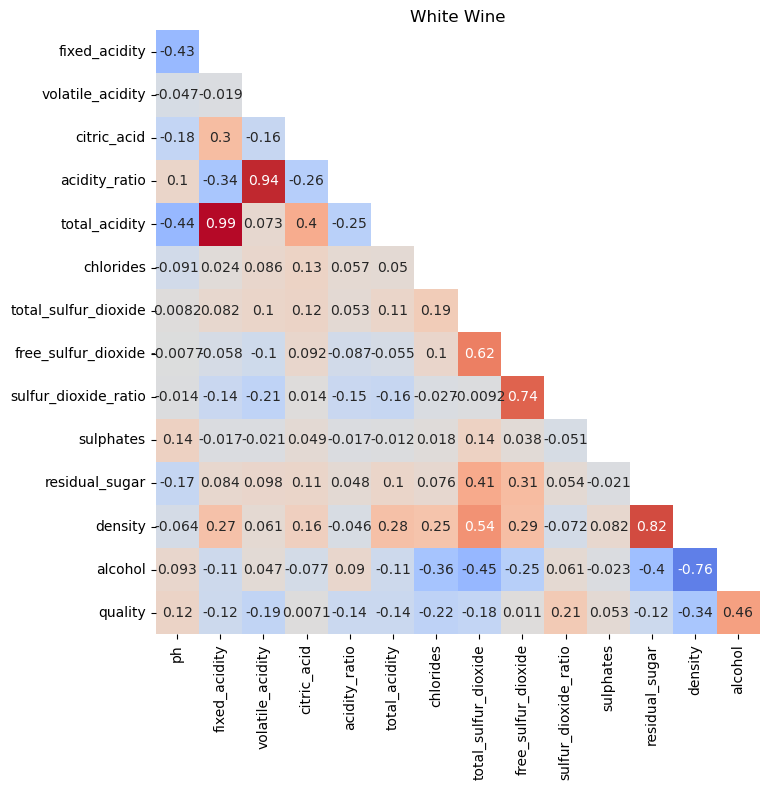

In [26]:
# plot correlation matrix for white wine
# TODO draw color bar
f, ax = plt.subplots(1, 1, figsize=(14, 8), sharex=True, sharey=True)
plot_corr_matrix(corr_w_2, ax)
ax.set_title('White Wine')
plt.tight_layout()

## High Quality Wines

In [27]:
# TODO What does this mean? Does this make sense? 
wine_w_hq = wine_w[wine_w.quality_label == 'high']
corr_w_hq = wine_w_hq[all_columns].corr(numeric_only=True)
corr_w_hq

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol,quality
ph,1.000000,-0.476945,-0.017963,-0.154398,0.017348,0.071162,0.015004,0.148444,-0.216611,-0.006992,-0.044435,NaN
fixed_acidity,-0.476945,1.000000,-0.085056,0.294754,0.113887,0.145907,-0.000382,-0.091217,0.185016,0.387871,-0.224869,NaN
volatile_acidity,-0.017963,-0.085056,1.000000,-0.278135,-0.242360,-0.045592,-0.187637,-0.010341,0.065594,-0.234016,0.477316,NaN
citric_acid,-0.154398,0.294754,-0.278135,1.000000,0.195541,0.153458,0.148608,-0.061943,0.074750,0.194869,-0.196552,NaN
chlorides,0.017348,0.113887,-0.242360,0.195541,1.000000,0.316474,0.208734,0.069509,0.119623,0.403928,-0.488534,NaN
total_sulfur_dioxide,0.071162,0.145907,-0.045592,0.153458,0.316474,1.000000,0.552222,0.033153,0.368197,0.515370,-0.380239,NaN
free_sulfur_dioxide,0.015004,-0.000382,-0.187637,0.148608,0.208734,0.552222,1.000000,0.145301,0.123487,0.194088,-0.210668,NaN
sulphates,0.148444,-0.091217,-0.010341,-0.061943,0.069509,0.033153,0.145301,1.000000,-0.084865,0.066230,-0.070149,NaN
residual_sugar,-0.216611,0.185016,0.065594,0.074750,0.119623,0.368197,0.123487,-0.084865,1.000000,0.757550,-0.329890,NaN
density,-0.006992,0.387871,-0.234016,0.194869,0.403928,0.515370,0.194088,0.066230,0.757550,1.000000,-0.794656,NaN


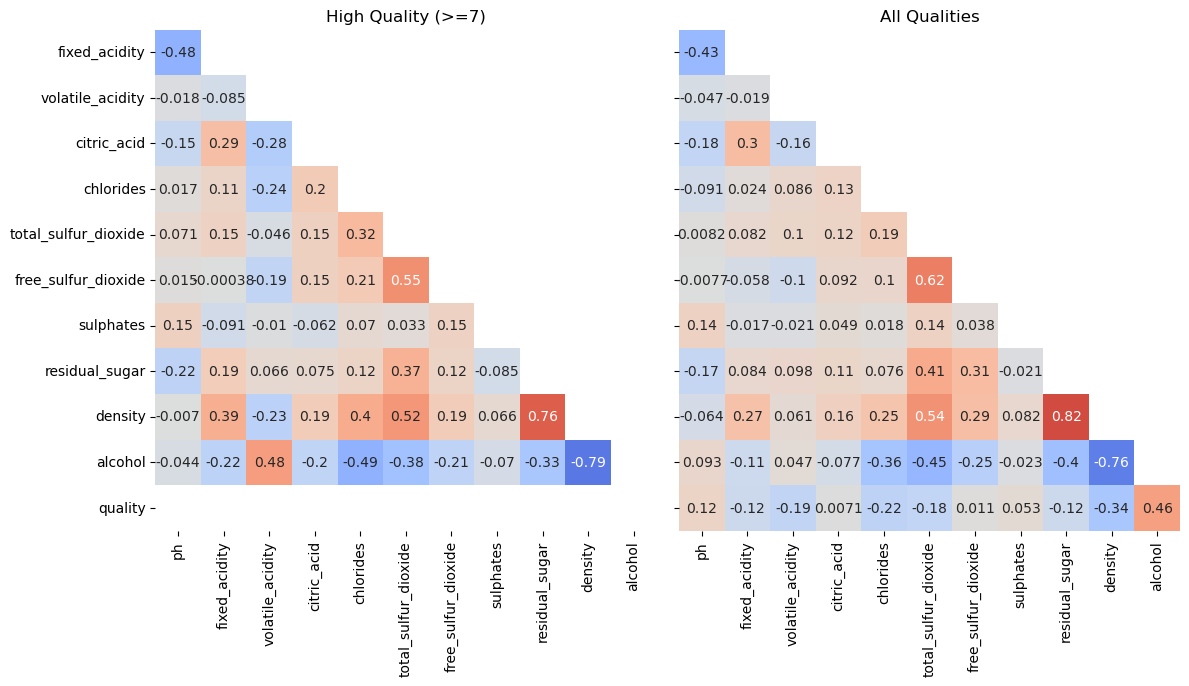

In [28]:

# Generate a mask for the upper triangle

fig, ax = plt.subplots(1, 2, figsize=(12, 10), sharex=True, sharey=True) # gridspec_kw={"width_ratios":[1, 1, 0.05]},
# ax = ax.flatten()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap='coolwarm'

plot_corr_matrix(corr_w_hq, ax[0])
plot_corr_matrix(corr_w, ax[1])

ax[0].set_title('High Quality (>=7)')
ax[1].set_title('All Qualities')

plt.tight_layout()

Interesting but not sure what this is supposed to tell me?! 

# Feature Collinearity

## Variance Inflation Factor 

In [29]:
# Calculate VIF for each feature
from statsmodels.stats.outliers_influence import variance_inflation_factor

x = wine_w[all_inputs]

vif_data = pd.DataFrame()
vif_data["Feature"] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

print(vif_data.sort_values('VIF'))

                 Feature          VIF
8         residual_sugar     3.511738
4              chlorides     5.989047
6    free_sulfur_dioxide     9.130488
2       volatile_acidity     9.672963
3            citric_acid    10.033242
7              sulphates    20.700587
5   total_sulfur_dioxide    24.538845
1          fixed_acidity    88.572299
10               alcohol   116.792244
0                     ph   606.325839
9                density  1049.318317


Note: VIF value greater than 10 is often considered indicative of high collinearity. The square root of the variance inflation factor indicates how much larger the standard error increases compared to if that variable had 0 correlation to other predictor variables in the model.

## Condition number 

In [30]:
from numpy.linalg import cond

# Calculate the condition number
condition_number = cond(x)
print(f"Condition Number: {condition_number}")

Condition Number: 7273.313533136984


The condition number is very high. A high condition number (greater than 30) indicates potential collinearity. Meaning that a solution to the problem is very hard to find.

# Plot Configuration

In [31]:
# plot configs
# TODO - how to transfer the config efficiently to the figures? 

# first, try a dictionary
wine_type_colors = {
    'red_wine'  :'red',
    'white_wine':'gray'
    }

quality_label_colors = {
    'low'          :'blue',
    'medium'       :'green',
    'high'         :'orange',
    'exceptionel'  :'gold'
    }

input_param_colors = {
    'fixed_acidity'         : 'darkorange',
    'volatile_acidity'      : 'burlywood',
    'citric_acid'           : 'antiquewhite',
    'ph'                    : 'chocolate',
    'chlorides'             : 'turquoise',
    'free_sulfur_dioxide'   : 'khaki',
    'total_sulfur_dioxide'  : 'gold',
    'sulphates'             : 'yellow',
    'residual_sugar'        : 'crimson',
    'density'               : 'cornflowerblue',
    'alcohol'               : 'blueviolet'
}

input_param_labels = {
    'fixed_acidity'         : 'Fixed Acidity',
    'volatile_acidity'      : 'Volatile Acidity',
    'citric_acid'           : 'Citric Acid',
    'ph'                    : 'pH',
    'chlorides'             : 'Chlorides',
    'free_sulfur_dioxide'   : 'Free Sulfur Dioxide',
    'total_sulfur_dioxide'  : 'Total Sulfur Dioxide',
    'sulphates'             : 'Sulphates',
    'residual_sugar'        : 'Residual Sugar',
    'density'               : 'Density',
    'alcohol'               : 'Alcohol'
}

# TODO second, try a class! Could be easier

# define variables; problem: in the end I will have many many variables in the space that I do not understand anymore
color_red = 'red'
color_white = 'gray'

# White Wine Quality

## Quality distribution

In [32]:
wine_w.quality.value_counts().sort_index()

quality
3      20
4     153
5    1175
6    1788
7     689
8     131
9       5
Name: count, dtype: int64

c:\Users\olive\anaconda3\envs\base_data_analysis\Lib\site-packages\numpy\ma\core.py:3463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  _data[indx] = dval


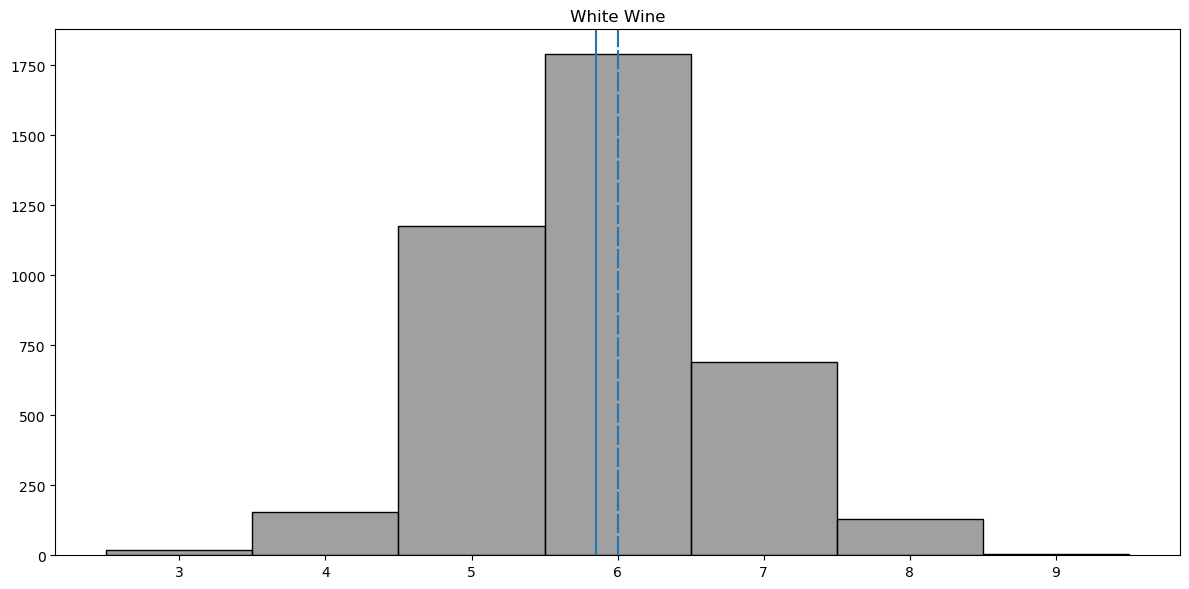

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12,6), sharey=True)

# NOTE draw bars in the middle of the value without gaps -> discrete=True
# NOTE kde does not make sense here
sns.histplot(wine_w.quality, color=color_white, discrete=True, ax=ax) #, kde=True)

ax.set_title('White Wine')
ax.set_xlabel('')
ax.set_ylabel('')

# show average, median and mode
ylim = ax.get_ylim() # TODO find a way to skip this workaround
ax.vlines(
    [wine_w.quality.mean(), wine_w.quality.median(), wine_w.quality.mode()],
    ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1],
    linestyles=['solid', '-.', '--']
)
ax.set_ylim(ylim)

plt.tight_layout()

In [34]:
quality_ratings = sorted(wine_w.quality.unique())
map_quality_label_vec = np.vectorize(lambda value: (
        'low' if value < 6 else 
        'medium' if value < 7 else 
        'high' if value < 8 else
        'exceptionel' 
    ))
list(zip(quality_ratings, map_quality_label_vec(quality_ratings)))

[(np.int64(3), np.str_('low')),
 (np.int64(4), np.str_('low')),
 (np.int64(5), np.str_('low')),
 (np.int64(6), np.str_('medium')),
 (np.int64(7), np.str_('high')),
 (np.int64(8), np.str_('exceptionel')),
 (np.int64(9), np.str_('exceptionel'))]

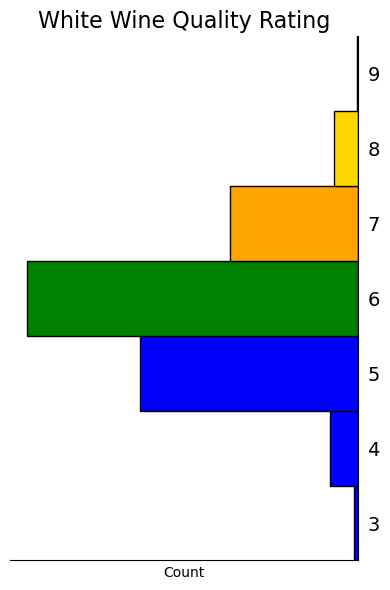

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(4,6), sharey=True)

# NOTE draw bars in the middle of the value without gaps -> discrete=True
# NOTE kde does not make sense here
sns.histplot(y=wine_w.quality, color=color_white, discrete=True, ax=ax) #, kde=True)

# TODO move to utils!
quality_ratings = sorted(wine_w.quality.unique())
map_quality_label_vec = np.vectorize(lambda value: (
        'low' if value < 6 else 
        'medium' if value < 7 else 
        'high' if value < 8 else
        'exceptionel' 
    ))
quality_ratings = map_quality_label_vec(quality_ratings) #list(zip(quality_ratings, map_quality_label(quality_ratings)))

for bars in ax.containers:
    for bar, qlabel in zip(bars, quality_ratings):
        bar.set_facecolor(quality_label_colors[qlabel])

ax.set_title('White Wine Quality Rating', fontsize=16)
ax.set_xlabel('Count')
ax.set_xticklabels('')
ax.set_xticks([])
# ax.set_xscale(lambda x: np.log1p(x))

# invert x-axis
xmin, xmax = plt.xlim()
plt.xlim(xmax, xmin)

ax.set_ylabel('')
ax.tick_params(axis='y', labelsize=14)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylim([2.5,9.5])

sns.despine(top=True, right=False, left=True, bottom=False)

plt.tight_layout()

- avg: 5.8. avg=median, mode: 6
- slighty negatively skewed, almost symmetric distribution
- conclusion
  - Kind of normally distributed data set
  - sample: average wine years, wines meet the expectations, maybe slightly more bad wines
  - tasters: testing might not be symmetric
  - good representation of sample and testers

## Physicochemical Profiles

In [36]:
wine_w_top10 = wine_w.sort_values('quality', ascending=False).head(10)
wine_w_top10

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,...,quality,color,quality_label,total_sulfur_dioxide_above_eu_limit,volatile_acid_above_eu_limit,sulfur_dioxide_ratio,acidity_ratio,total_acidity,input_outlier_count,input_outliers_if
1605,3.37,7.1,0.260,0.49,0.032,113.0,31.0,0.42,2.20,0.99030,...,9,white,exceptionel,False,False,0.274336,0.036620,7.850,0,False
774,3.20,9.1,0.270,0.45,0.035,124.0,28.0,0.46,10.60,0.99700,...,9,white,exceptionel,False,False,0.225806,0.029670,9.820,1,False
827,3.28,7.4,0.240,0.36,0.031,139.0,27.0,0.48,2.00,0.99055,...,9,white,exceptionel,False,False,0.194245,0.032432,8.000,0,False
820,3.41,6.6,0.360,0.29,0.021,85.0,24.0,0.61,1.60,0.98965,...,9,white,exceptionel,False,False,0.282353,0.054545,7.250,0,False
876,3.28,6.9,0.360,0.34,0.018,119.0,57.0,0.36,4.20,0.98980,...,9,white,exceptionel,False,False,0.478992,0.052174,7.600,0,False
4786,3.46,4.4,0.320,0.39,0.030,127.0,31.0,0.36,4.30,0.98904,...,8,white,exceptionel,False,False,0.244094,0.072727,5.110,1,False
22,3.47,6.8,0.260,0.42,0.049,122.0,41.0,0.48,1.70,0.99300,...,8,white,exceptionel,False,False,0.336066,0.038235,7.480,0,False
4787,3.57,3.9,0.225,0.40,0.030,118.0,29.0,0.36,4.20,0.98900,...,8,white,exceptionel,False,False,0.245763,0.057692,4.525,1,False
17,3.33,6.2,0.660,0.48,0.029,75.0,29.0,0.39,1.20,0.98920,...,8,white,exceptionel,False,False,0.386667,0.106452,7.340,1,True
2774,3.09,7.0,0.360,0.32,0.045,131.0,37.0,0.33,10.05,0.99352,...,8,white,exceptionel,False,False,0.282443,0.051429,7.680,0,False


In [37]:
wine_w_norm_top10 = wine_w_norm.sort_values('quality', ascending=False).head(10)
wine_w_norm_top10

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol,quality,quality_label
1605,0.590909,0.317308,0.176471,0.295181,0.068249,0.241299,0.101045,0.232558,0.024540,0.061500,0.790323,9,exceptionel
774,0.436364,0.509615,0.186275,0.271084,0.077151,0.266821,0.090592,0.279070,0.153374,0.190669,0.387097,9,exceptionel
827,0.509091,0.346154,0.156863,0.216867,0.065282,0.301624,0.087108,0.302326,0.021472,0.066320,0.725806,9,exceptionel
820,0.627273,0.269231,0.274510,0.174699,0.035608,0.176334,0.076655,0.453488,0.015337,0.048969,0.709677,9,exceptionel
876,0.509091,0.298077,0.274510,0.204819,0.026706,0.255220,0.191638,0.162791,0.055215,0.051860,0.758065,9,exceptionel
4786,0.672727,0.057692,0.235294,0.234940,0.062315,0.273782,0.101045,0.162791,0.056748,0.037208,0.774194,8,exceptionel
22,0.681818,0.288462,0.176471,0.253012,0.118694,0.262181,0.135889,0.302326,0.016871,0.113553,0.403226,8,exceptionel
4787,0.772727,0.009615,0.142157,0.240964,0.062315,0.252900,0.094077,0.162791,0.055215,0.036437,0.774194,8,exceptionel
17,0.554545,0.230769,0.568627,0.289157,0.059347,0.153132,0.094077,0.197674,0.009202,0.040293,0.774194,8,exceptionel
2774,0.336364,0.307692,0.274510,0.192771,0.106825,0.283063,0.121951,0.127907,0.144939,0.123578,0.596774,8,exceptionel


c:\Users\olive\OneDrive\Documents\arbeiten\weiterbildung\Data Science Arbeitsamt\Project-2_wine_quality\src\utils.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(labels=ylabels)


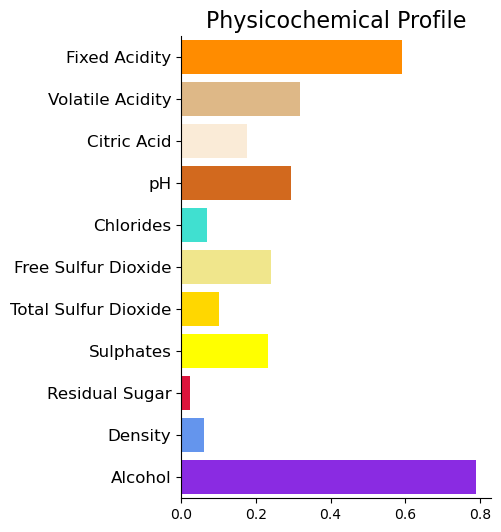

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(4,6))
ax = barplot_physicochemical_properties(wine_w_norm_top10.iloc[0][all_inputs], input_param_colors.values(), input_param_labels.values())
ax.set_title('Physicochemical Profile', fontsize=16)
ax.tick_params(axis='y', labelsize=12)
# ax.title_params()
sns.despine()

c:\Users\olive\OneDrive\Documents\arbeiten\weiterbildung\Data Science Arbeitsamt\Project-2_wine_quality\src\utils.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(labels=ylabels)
c:\Users\olive\OneDrive\Documents\arbeiten\weiterbildung\Data Science Arbeitsamt\Project-2_wine_quality\src\utils.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(labels=ylabels)
c:\Users\olive\OneDrive\Documents\arbeiten\weiterbildung\Data Science Arbeitsamt\Project-2_wine_quality\src\utils.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(labels=ylabels)
c:\Users\olive\OneDrive\Documents\arbeiten\weiterbildung\Data Science Arbeitsamt\Project-2_wine_quality\src\utils.py:13: UserWarning: set_ticklab

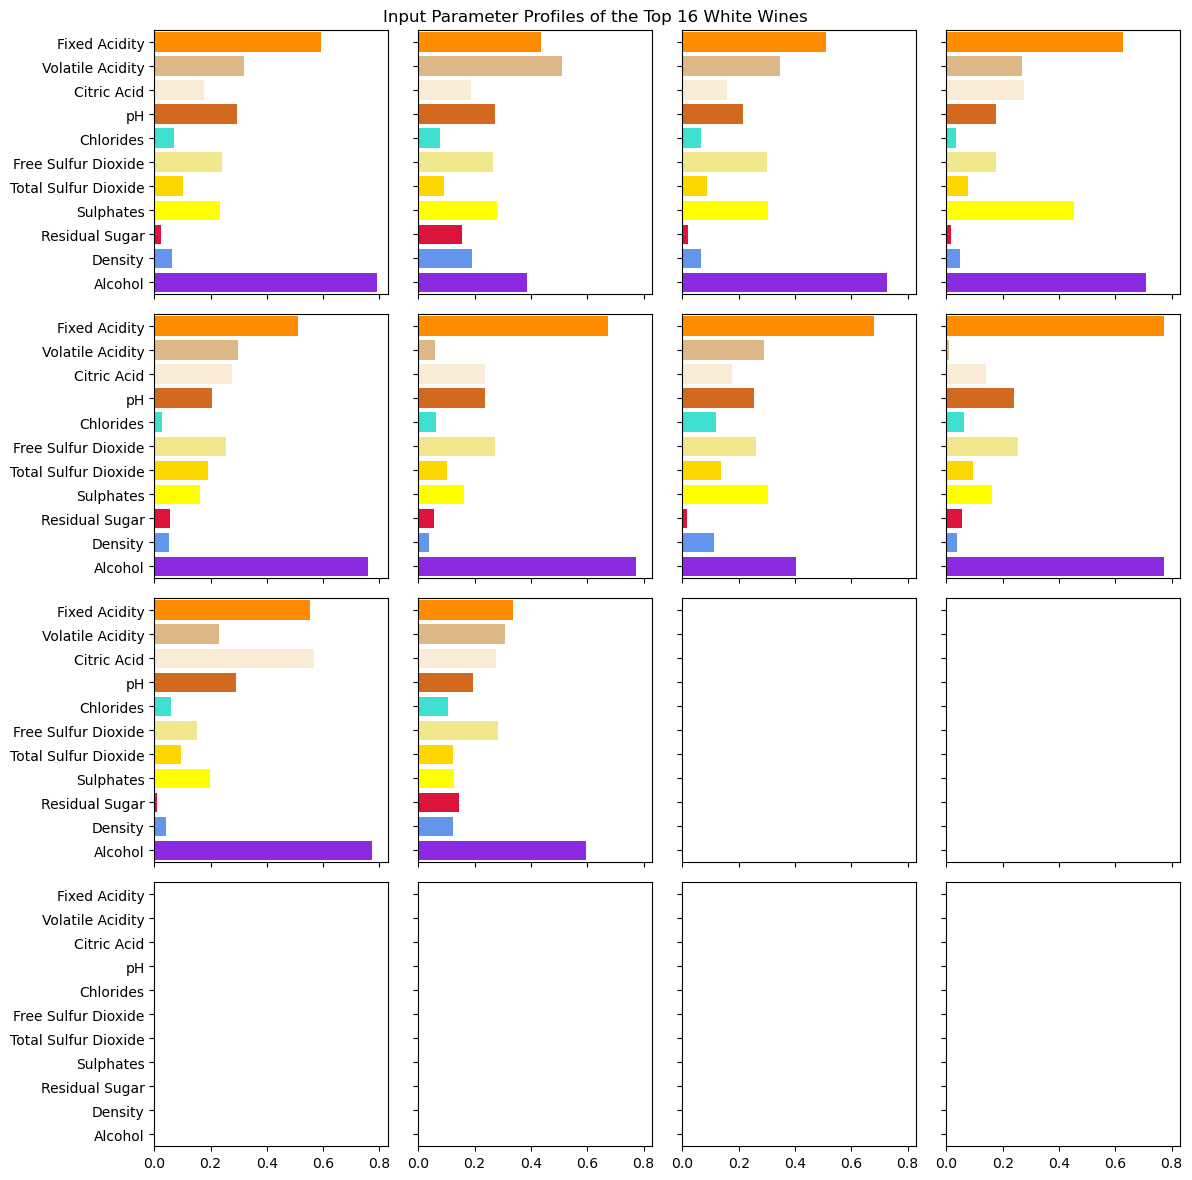

In [39]:
# plot physiochemical profile of the top wines
fig,ax = plt.subplots(4,4, figsize=(12,12), sharex=True, sharey=True)
ax = ax.flatten()

plt.suptitle('Input Parameter Profiles of the Top 16 White Wines')

for w, a in zip(wine_w_norm_top10[all_inputs].values, ax):
   barplot_physicochemical_properties(w, input_param_colors.values(), input_param_labels.values(), a)

# take away the spines
# sns.despine()

plt.tight_layout()

## Quality Label distribution

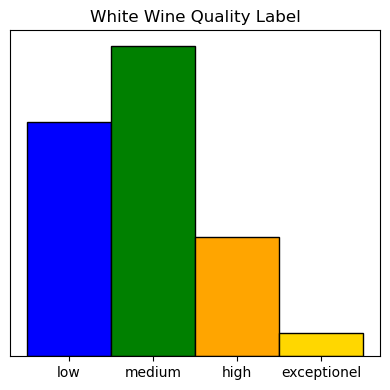

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), sharex=True, sharey=True)

# NOTE stat = density for normalization
sns.histplot(wine_w.quality_label, color=color_white, ax=ax) 

for bars in ax.containers:
    for bar, color in zip(bars, quality_label_colors.values()):
        bar.set_facecolor(color)

ax.set_title('White Wine Quality Label')
ax.set_xlabel('')
ax.set_ylabel('')
ax.get_yticklabels([])
ax.set_yticks([])
plt.tight_layout()

In [41]:
wine_w.quality_label.value_counts().sort_index()

quality_label
low            1348
medium         1788
high            689
exceptionel     136
Name: count, dtype: int64

Questions: 
- move the quality label?
- create a new quality label based on the high quality wines? 

Follow-Up Tasks
- Investigate high quality wines for similarities in chemical composition. Is there a composition that convinced the testers the most?
-  

## Alcohol vs. Wine Quality

### Quality Rating

Text(0.5, 1.0, 'Alcohol vs Quality Rating')

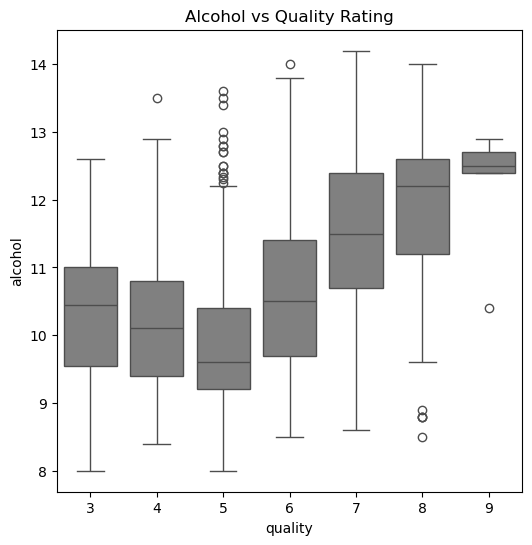

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True, sharey=True)
sns.boxplot(wine_w, y='alcohol', x='quality', color=wine_type_colors['white_wine'], ax=ax)
ax.set_title('Alcohol vs Quality Rating')

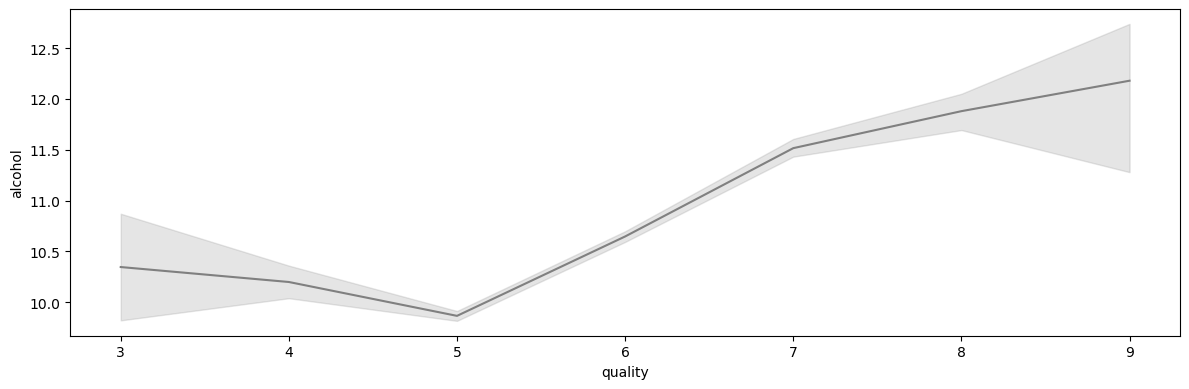

In [43]:
# TODO plot the averages and std
fig, ax = plt.subplots(1, 1, figsize=(12,4))

sns.lineplot(wine_w, x='quality', y='alcohol', color=wine_type_colors['white_wine'], ax=ax)

plt.tight_layout()

- Alcohol content is an indicator of good wine, however it's not decisive, because low quality wines also have a high alcohol content
- Alcohol, Alcohol and Residual Sugar are indicators of the fermentation process.
- Usually 50% of the input sugar can be turned into alcohol before fermentation stops.

#### Questions
- Is there a reason for this distribution?

#### Tasks
- Investigate the increase from rating of 5; cut out the bad wines, to find out a what's a good wine.

### Quality Labels

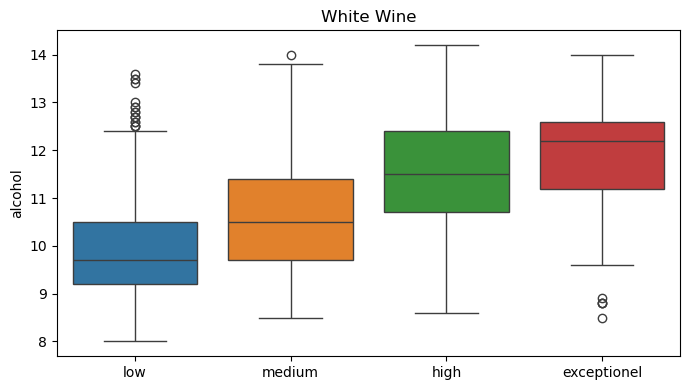

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(7,4), sharex=True, sharey=True)

sns.boxplot(wine_w, x='quality_label', y='alcohol', hue='quality_label', ax=ax)

ax.set_title('White Wine')
ax.set_xlabel('')

plt.tight_layout()

### ANOVA Testing with ANOVA Welch ANOVA, Kruskal-Wallis  

In [45]:
# test if ANOVA assumptions are met
print('Data should be normally distributed:\n', pg.normality(wine_w, dv='alcohol', group='quality_label'))
print()
print('Variances should be similar:\n', wine_w.groupby('quality_label').alcohol.var())

Data should be normally distributed:
                       W          pval  normal
quality_label                                
medium         0.971576  2.504234e-18   False
low            0.934381  6.742571e-24   False
high           0.987361  1.141580e-05   False
exceptionel    0.922964  9.793153e-07   False

Variances should be similar:
 quality_label
low            0.802089
medium         1.273287
high           1.320693
exceptionel    1.111922
Name: alcohol, dtype: float64


C:\Users\olive\AppData\Local\Temp\ipykernel_10080\1054401453.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print('Variances should be similar:\n', wine_w.groupby('quality_label').alcohol.var())


In [46]:
# use Welch ANOVA
pg.welch_anova(wine_w, dv='alcohol', between='quality_label').T

,0
Source,quality_label
ddof1,3
ddof2,591.985885
F,462.179976
p-unc,0.0
np2,0.247419


In [47]:
f,p = stats.kruskal(
    wine_w.loc[wine_w.quality_label=='low', 'alcohol'],
    wine_w.loc[wine_w.quality_label=='medium', 'alcohol'],
    wine_w.loc[wine_w.quality_label=='high', 'alcohol']
)

print(f,p)

821.594631614562 3.917351699596694e-179


In [48]:
# for comparison: ANOVA TEST on quality label and alcohol content
f,p = stats.f_oneway(
    wine_w.loc[wine_w.quality_label=='low', 'alcohol'],
    wine_w.loc[wine_w.quality_label=='medium', 'alcohol'],
    wine_w.loc[wine_w.quality_label=='high', 'alcohol']
)

print(f, p)

543.4189588474807 1.982499655326959e-208


### Conclusions on quality distribution

- High quality wines tend to have a higher alcohol content.
- The range is however very large.
- Although there is a strong, positive correlation between quality alcohol, the outliers show that this is not a conclusive measure for quality.
- Medium quality wines have a low alcohol content, but there are many outliers with a very high alcohol content in this group.

Questions
- What are the features of medium quality wines?
- How do wines get a high alcohol content?
  - yeast turns sugar into alcohol and ??? 
  - residual sugar -> sweetness
  - What about density?
  - acidity

## Density vs. Wine Quality 

<Axes: xlabel='quality', ylabel='density'>

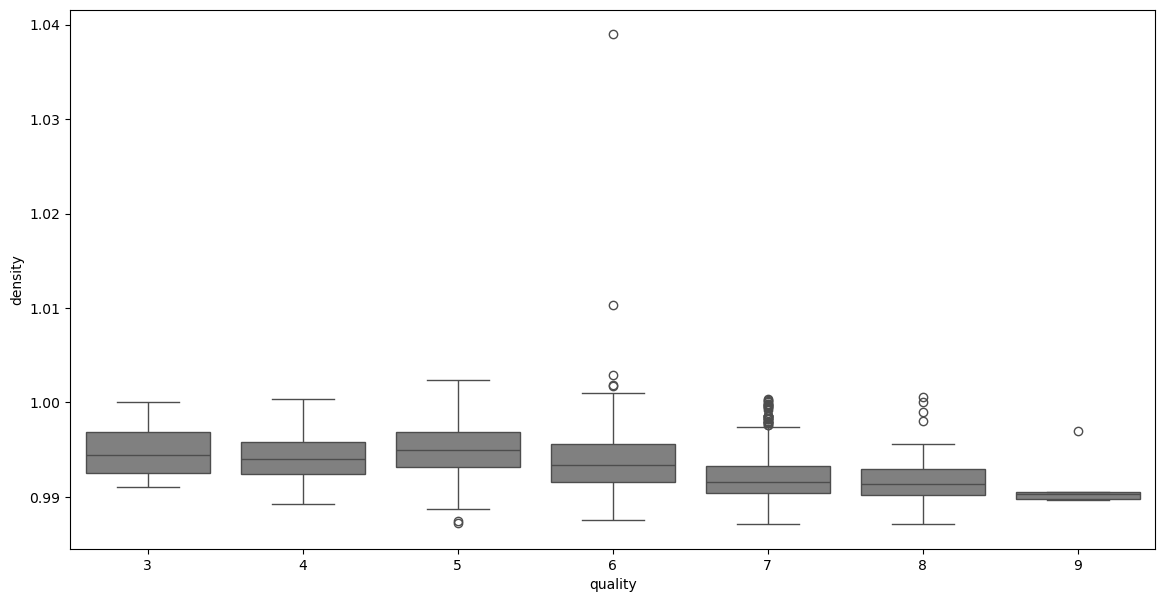

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
sns.boxplot(wine_w, x='quality', y='density', color=wine_type_colors['white_wine'], ax=ax)

# new_ylim = [ax[1].get_ylim()[0], ax[0].get_ylim()[1]]
# ax[0].set_ylim(new_ylim)
# ax[1].set_ylim(new_ylim)

In [50]:
wine_w.loc[wine_w.density.sort_values(ascending=False).index,:].head()

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,...,quality,color,quality_label,total_sulfur_dioxide_above_eu_limit,volatile_acid_above_eu_limit,sulfur_dioxide_ratio,acidity_ratio,total_acidity,input_outlier_count,input_outliers_if
2781,3.39,7.8,0.965,0.60,0.074,160.0,8.0,0.69,65.80,1.03898,...,6,white,medium,False,False,0.050000,0.123718,9.365,2,True
1653,3.15,7.9,0.330,0.28,0.053,176.0,35.0,0.38,31.60,1.01030,...,6,white,medium,False,False,0.198864,0.041772,8.510,0,True
3619,3.06,6.8,0.450,0.28,0.031,122.0,27.0,0.42,26.05,1.00295,...,6,white,medium,False,False,0.221311,0.066176,7.530,0,True
2334,3.44,7.5,0.230,0.35,0.058,212.0,128.0,0.43,17.80,1.00241,...,5,white,low,True,False,0.603774,0.030667,8.080,1,True
1608,2.98,6.9,0.270,0.49,0.057,235.0,59.0,0.47,23.50,1.00240,...,5,white,low,True,False,0.251064,0.039130,7.660,0,True


Question:
- What is wine density? 

## Residual Sugar vs. Wine Quality 

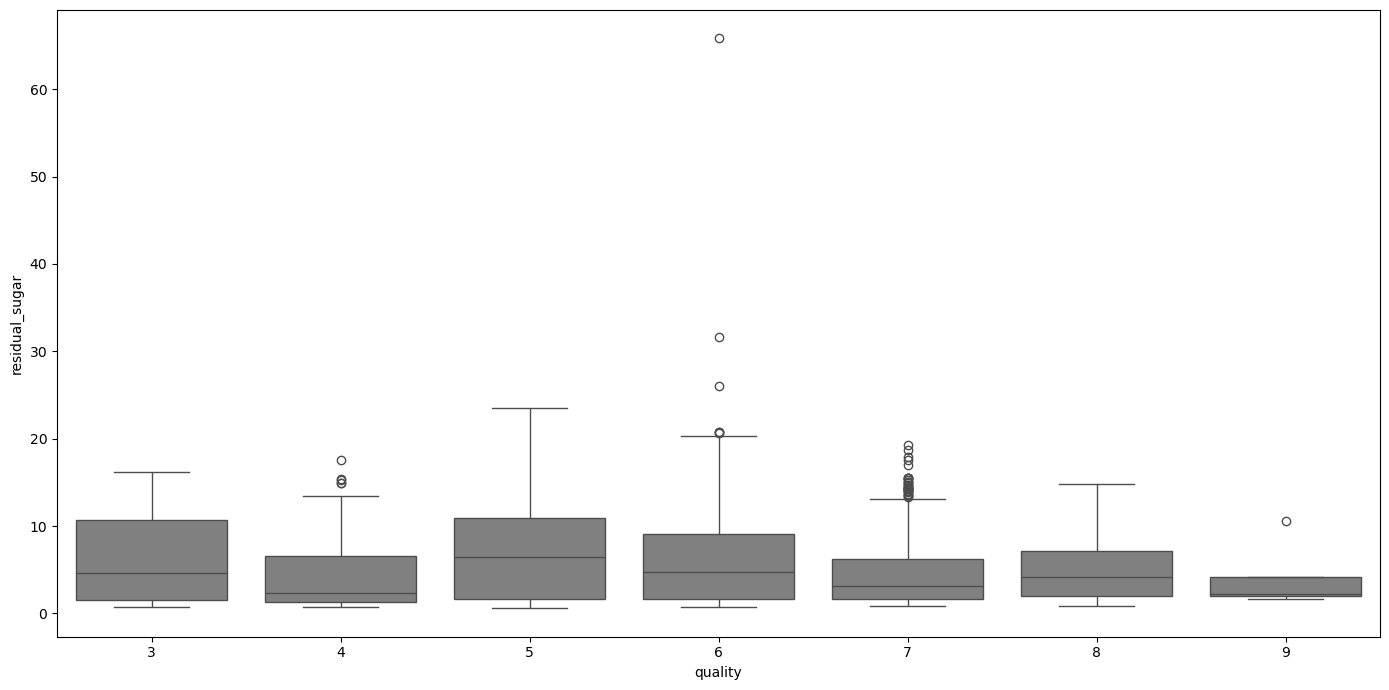

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
sns.boxplot(wine_w, y='residual_sugar', x='quality', color=wine_type_colors['white_wine'], ax=ax)
plt.tight_layout()

## Sulphates vs. Wine Quality

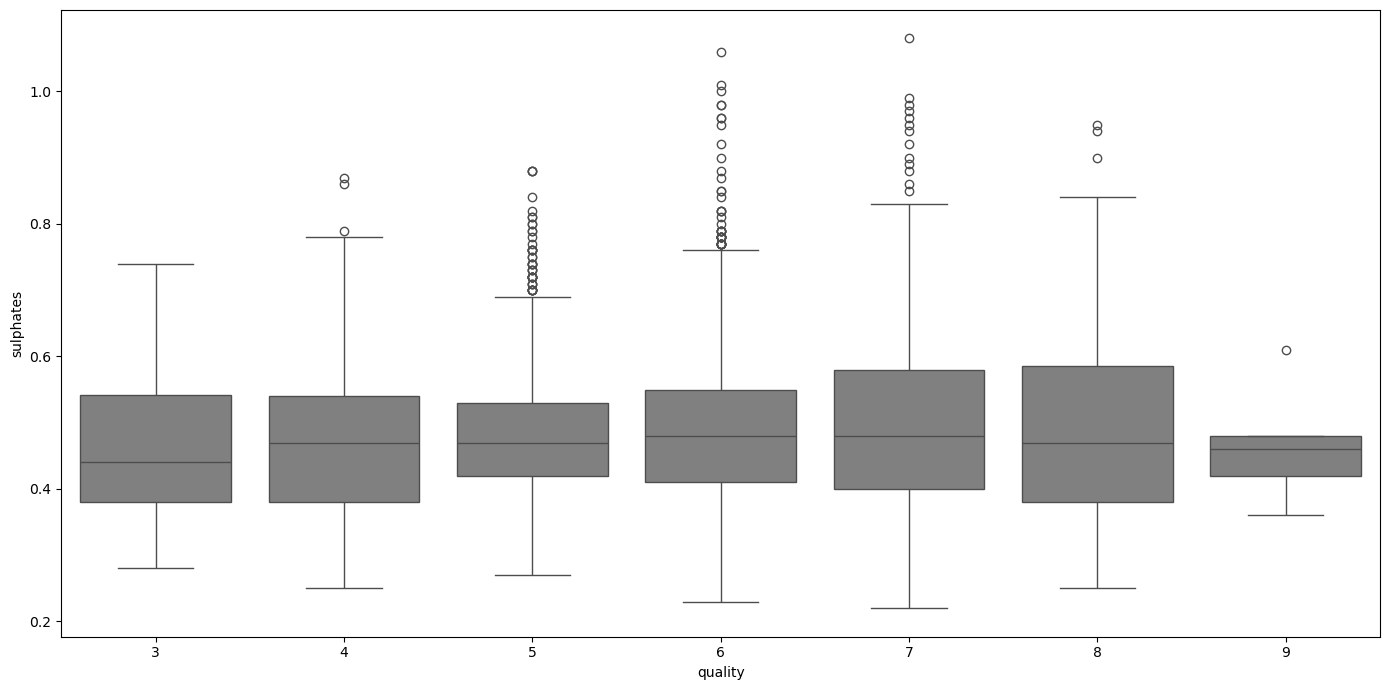

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
sns.boxplot(wine_w, x='quality', y='sulphates', color=wine_type_colors['white_wine'], ax=ax)
plt.tight_layout()

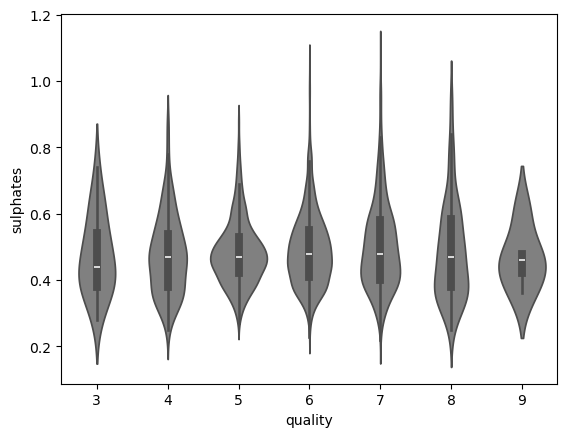

In [53]:
# fig, ax = plt.subplots(1, 2)
jg = sns.violinplot(data=wine_w, x="quality", y="sulphates", color=wine_type_colors['white_wine'])
# plt.tight_layout()

## Fixed Acidity vs. Wine Quality

<Axes: xlabel='quality', ylabel='fixed_acidity'>

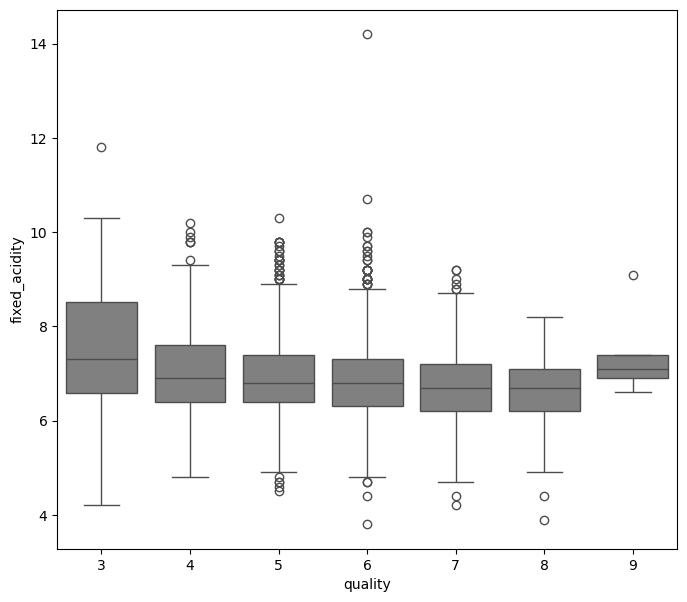

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))
sns.boxplot(wine_w, x='quality', y='fixed_acidity', color=wine_type_colors['white_wine'], ax=ax)

## Volatile Acidity vs. Wine Quality

<Axes: xlabel='quality', ylabel='volatile_acidity'>

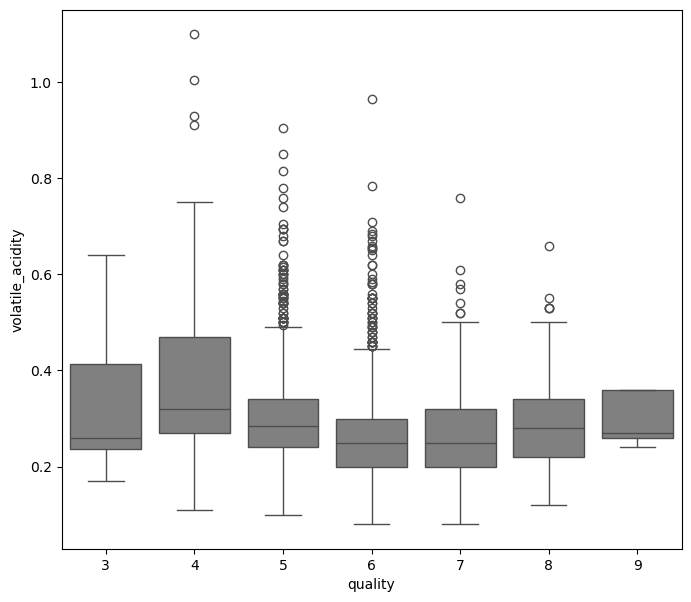

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))
sns.boxplot(wine_w, x='quality', y='volatile_acidity', color=wine_type_colors['white_wine'], ax=ax)

<Axes: xlabel='quality', ylabel='volatile_acidity'>

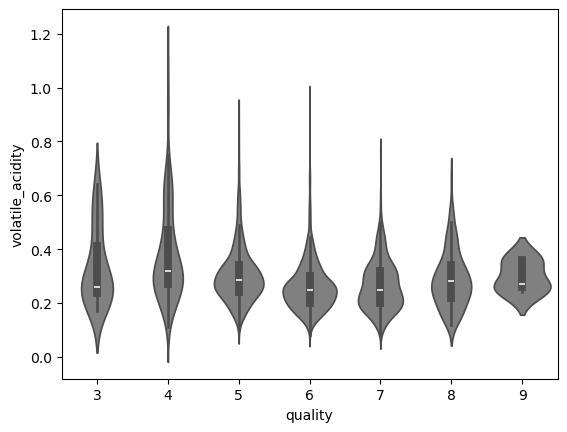

In [56]:
sns.violinplot(data=wine_w, x="quality", y="volatile_acidity", color=wine_type_colors['white_wine'])

## Chlorides vs Wine Quality

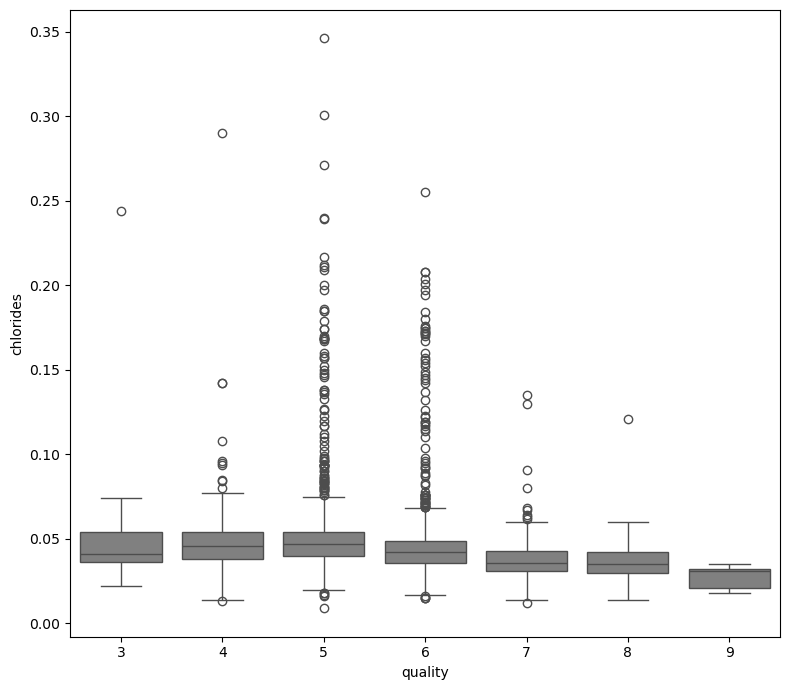

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))
sns.boxplot(wine_w, x='quality', y='chlorides', color=wine_type_colors['white_wine'], ax=ax)
plt.tight_layout()

## pH vs Wine Quality

In [58]:
sns.violinplot(wine_w, x='quality', y='ph', ax=ax)

<Axes: xlabel='quality', ylabel='chlorides'>

### pH vs residual sugar vs wine quality

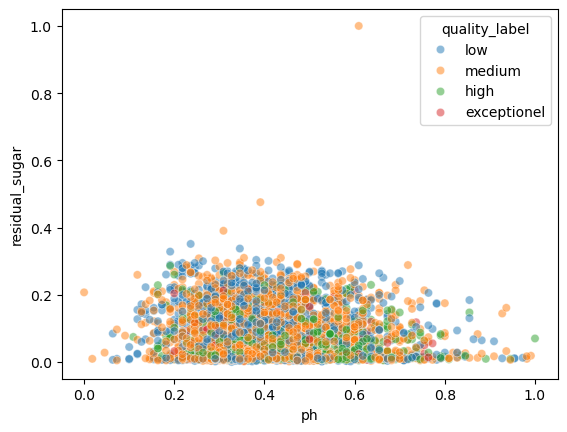

In [59]:
ax = sns.scatterplot(
    wine_w_norm,
    y='residual_sugar',
    x='ph',
    hue='quality_label',
    alpha=0.5
)

As you can see you can't see anything!

## High Quality Wines

Check the correlations on high quality wine in order to see if there's a difference.

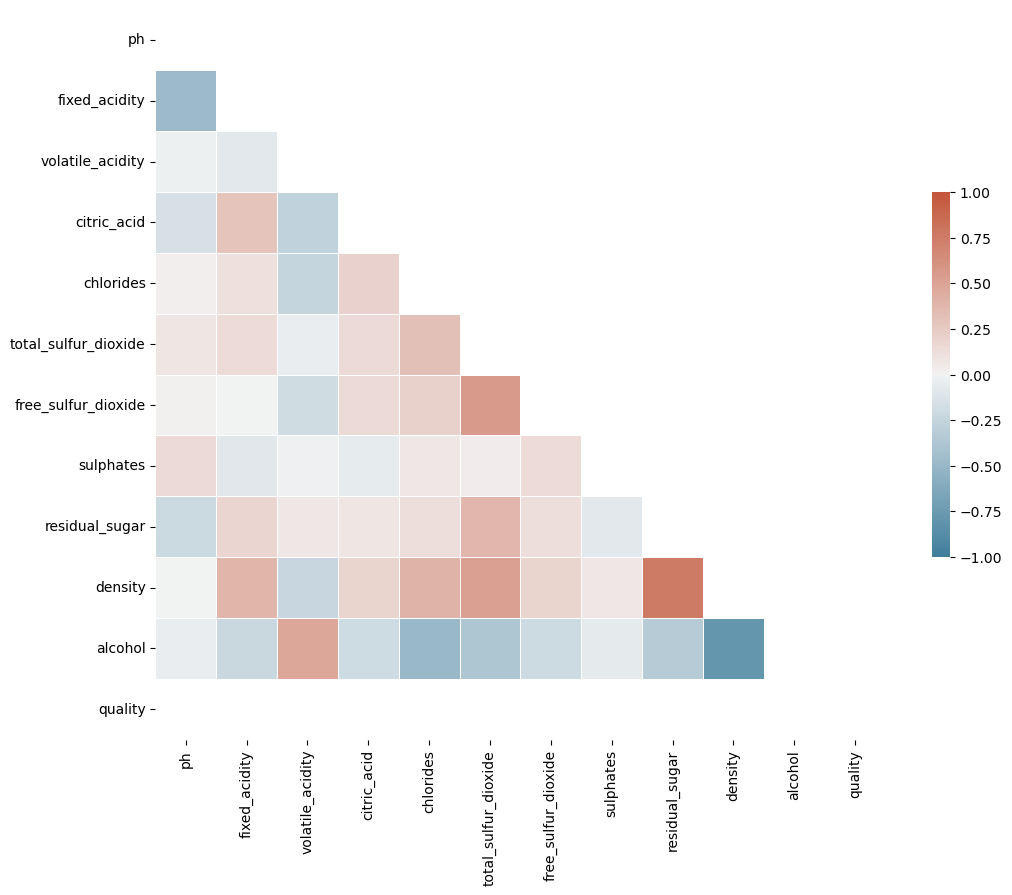

In [60]:
# TODO What does this mean? Does this make sense? 
wine_w_hq = wine_w[wine_w.quality_label == 'high']
corr_wine_w_hq = wine_w_hq[all_columns].corr(numeric_only=True)
corr_wine_w_hq


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_wine_w_hq, dtype=bool))

fig, ax = plt.subplots(figsize=(11, 9))#,  sharex=True, sharey=True) # gridspec_kw={"width_ratios":[1, 1, 0.05]},
# ax = ax.flatten()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
cplot_wine_w = sns.heatmap(corr_wine_w_hq, mask=mask, 
            cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            cbar=True
            )

plt.tight_layout()

## Alcohol, Density, Chlorides, Residual Sugar, Quality

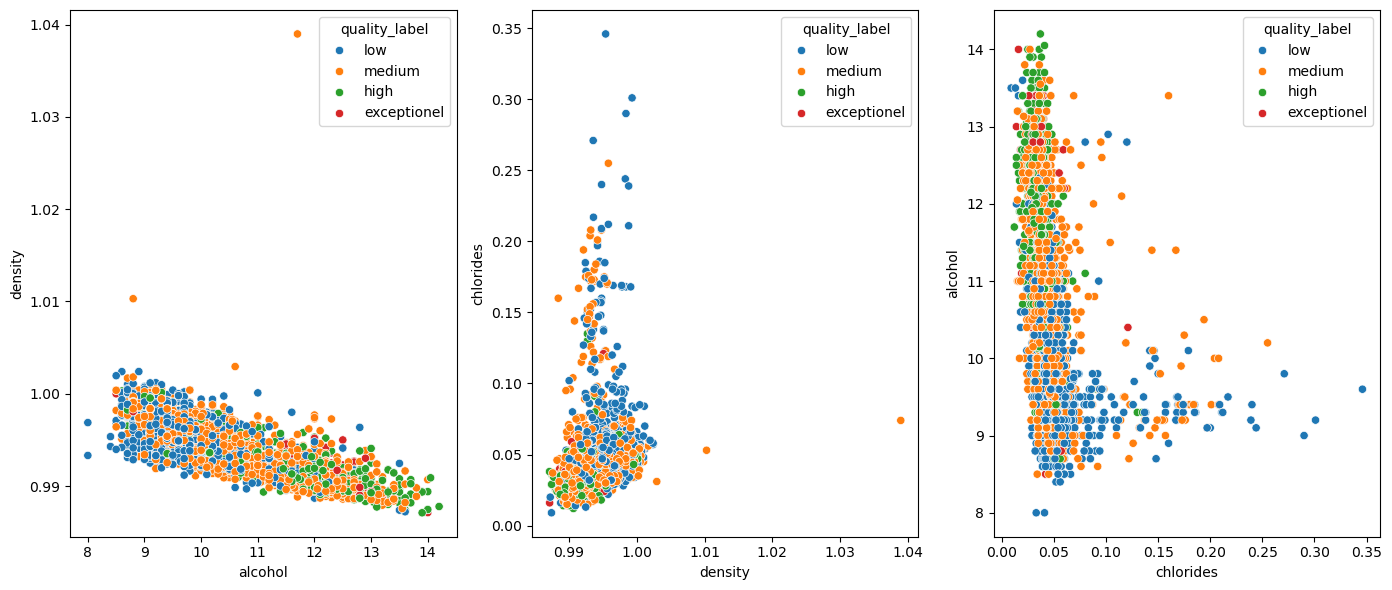

In [61]:
fig,ax = plt.subplots(1, 3, figsize=(14,6))

sns.scatterplot(wine_w, x='alcohol', y='density', hue='quality_label', ax=ax[0])
sns.scatterplot(wine_w, x='density', y='chlorides', hue='quality_label', ax=ax[1])
sns.scatterplot(wine_w, x='chlorides', y='alcohol', hue='quality_label', ax=ax[2])

plt.tight_layout()

## Alcohol, Density, Quality

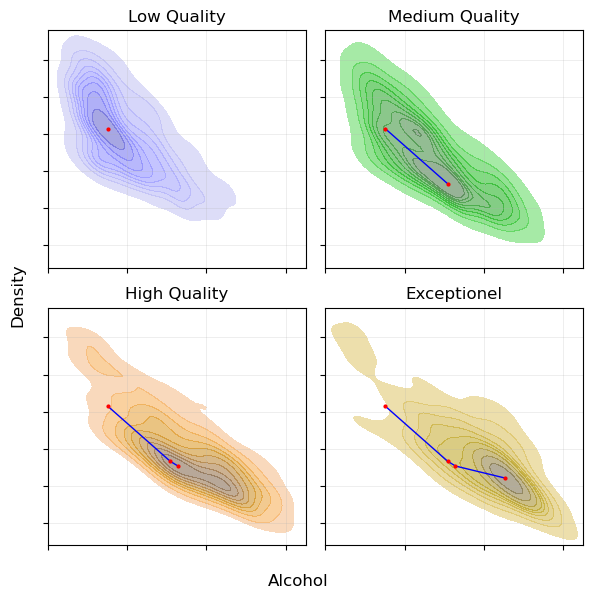

In [62]:
# alcohol density relation: show the overlap of the quality levels and the tendencies of good wines
# How does the relation between two continuous variables split on a third categorical one?
# TODO create function: include set titles and colors, function to highlight a group
fig,ax = plt.subplots(2, 2, figsize=(6,6), sharex=True, sharey=True)
ax = ax.flatten()

low = wine_w.quality_label == 'low'
med = wine_w.quality_label == 'medium'
hig = wine_w.quality_label == 'high'
vhig = wine_w.quality_label == 'exceptionel'

# sns.scatterplot (wine_w_norm     , x='alcohol', y='density', hue='quality_label', alpha=0.7,  ax=ax[0,0])
sns.kdeplot(wine_w[low], x='alcohol', y='density', fill=True, alpha=0.5, color=quality_label_colors['low'], ax=ax[0])
sns.kdeplot(wine_w[med], x='alcohol', y='density', fill=True, alpha=0.5, color=quality_label_colors['medium'], ax=ax[1])
sns.kdeplot(wine_w[hig], x='alcohol', y='density', fill=True, alpha=0.5, color=quality_label_colors['high'], ax=ax[2])
sns.kdeplot(wine_w[vhig], x='alcohol', y='density', fill=True, alpha=0.5, color=quality_label_colors['exceptionel'], ax=ax[3])

# only show the interesting area (wo the high density outlier)
xlim = [8, 14.5]
ylim = [0.986, 1.002]
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)

# show the movement of the clouds by indicating the movement of the maxima
xmax, ymax = [0]*4, [0]*4
xmax[0], ymax[0], _ = get_kde_maximum(wine_w[low], 'alcohol', 'density', xlim, ylim)
xmax[1], ymax[1], _ = get_kde_maximum(wine_w[med], 'alcohol', 'density', xlim, ylim)
xmax[2], ymax[2], _ = get_kde_maximum(wine_w[hig], 'alcohol', 'density', xlim, ylim)
xmax[3], ymax[3], _ = get_kde_maximum(wine_w[vhig], 'alcohol', 'density', xlim, ylim)

connect_points_line(xmax[:2], ymax[:2], ax[1])
connect_points_line(xmax[:3], ymax[:3], ax[2])
connect_points_line(xmax, ymax, ax[3])

draw_points(xmax[:1], ymax[:1], ax[0])
draw_points(xmax[:2], ymax[:2], ax[1])
draw_points(xmax[:3], ymax[:3], ax[2])
draw_points(xmax, ymax, ax[3])

# tune plot
ax[0].grid(True, axis='both', linewidth=0.5, alpha=0.3)
ax[1].grid(True, axis='both', linewidth=0.5, alpha=0.3)
ax[2].grid(True, axis='both', linewidth=0.5, alpha=0.3)
ax[3].grid(True, axis='both', linewidth=0.5, alpha=0.3)

ax[0].set_yticklabels([])
ax[0].set_xticklabels([])

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
ax[3].set_xlabel('')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')

ax[0].set_title('Low Quality')
ax[1].set_title('Medium Quality')
ax[2].set_title('High Quality')
ax[3].set_title('Exceptionel')

fig.supxlabel('Alcohol')
fig.supylabel('Density')

plt.tight_layout()

# Inputs

In [63]:
wine_w[all_inputs].describe().T

,count,mean,std,min,25%,50%,75%,max
ph,3961.0,3.195458,0.151546,2.72000,3.09000,3.1800,3.29000,3.82000
fixed_acidity,3961.0,6.839346,0.866860,3.80000,6.30000,6.8000,7.30000,14.20000
volatile_acidity,3961.0,0.280538,0.103437,0.08000,0.21000,0.2600,0.33000,1.10000
citric_acid,3961.0,0.334332,0.122446,0.00000,0.27000,0.3200,0.39000,1.66000
chlorides,3961.0,0.045905,0.023103,0.00900,0.03500,0.0420,0.05000,0.34600
total_sulfur_dioxide,3961.0,137.193512,43.129065,9.00000,106.00000,133.0000,166.00000,440.00000
free_sulfur_dioxide,3961.0,34.889169,17.210021,2.00000,23.00000,33.0000,45.00000,289.00000
sulphates,3961.0,0.490351,0.113523,0.22000,0.41000,0.4800,0.55000,1.08000
residual_sugar,3961.0,5.914819,4.861646,0.60000,1.60000,4.7000,8.90000,65.80000
density,3961.0,0.993790,0.002905,0.98711,0.99162,0.9935,0.99571,1.03898


## Fixed Acidity

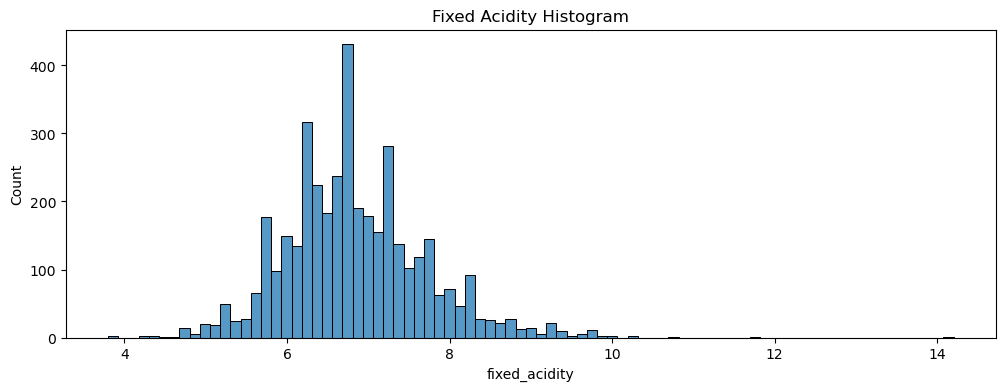

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))#, sharey=True)
sns.histplot(wine_w, x='fixed_acidity', ax=ax)
ax.set_title('Fixed Acidity Histogram')
plt.show()

In [65]:
# TODO move to utils!
def print_normality_report(series: pd.Series):
    print('normally distributed', '\t', pg.normality(series).iloc[0].loc['normal'])
    print('skew', '\t\t\t', series.skew())
    print('kurtosis', '\t\t', series.kurtosis())

In [66]:
print_normality_report(wine_w.fixed_acidity)

normally distributed 	 False
skew 			 0.6961002189465597
kurtosis 		 2.253047397588263


In [67]:
print_normality_report(wine_w[mask_w_wo_outliers].fixed_acidity)

normally distributed 	 False
skew 			 0.201137540207647
kurtosis 		 -0.13693759858216703


## Volatile Acidity

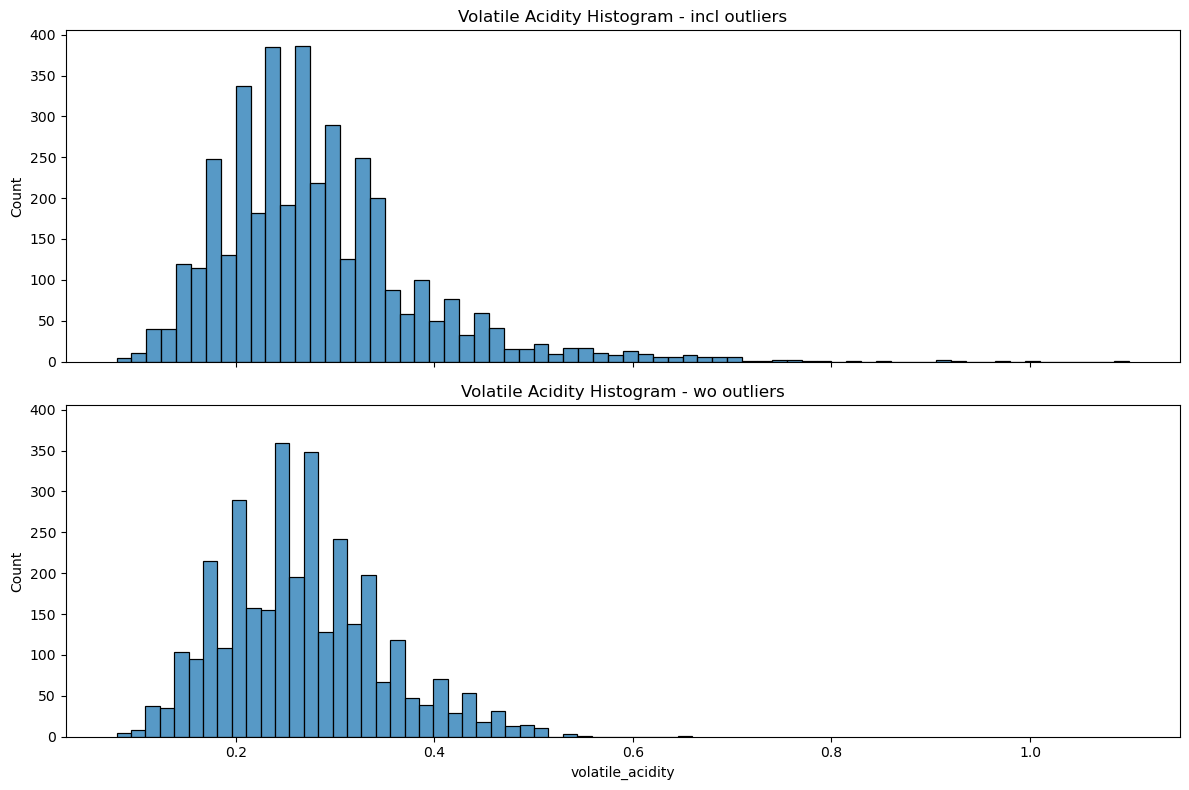

In [68]:
log_scale = False
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True, sharey=True)
sns.histplot(wine_w, x='volatile_acidity', log_scale=log_scale, ax=ax[0])
sns.histplot(wine_w[mask_w_wo_outliers], x='volatile_acidity', log_scale=log_scale, ax=ax[1])
ax[0].set_title('Volatile Acidity Histogram - incl outliers')
ax[1].set_title('Volatile Acidity Histogram - wo outliers')
plt.tight_layout()

In [69]:
print_normality_report(wine_w.volatile_acidity)

normally distributed 	 False
skew 			 1.6410809789536034
kurtosis 		 5.327754000428026


Thing is skewed!

In [70]:
print_normality_report(wine_w.volatile_acidity.apply(lambda x: np.log(x) if x>0 else None))

normally distributed 	 False
skew 			 0.17199426149320712
kurtosis 		 0.46138637689816875


In [71]:
print_normality_report(wine_w[mask_w_wo_outliers].volatile_acidity)

normally distributed 	 False
skew 			 0.5554110710960822
kurtosis 		 0.26016734861260193


## Citric Acid

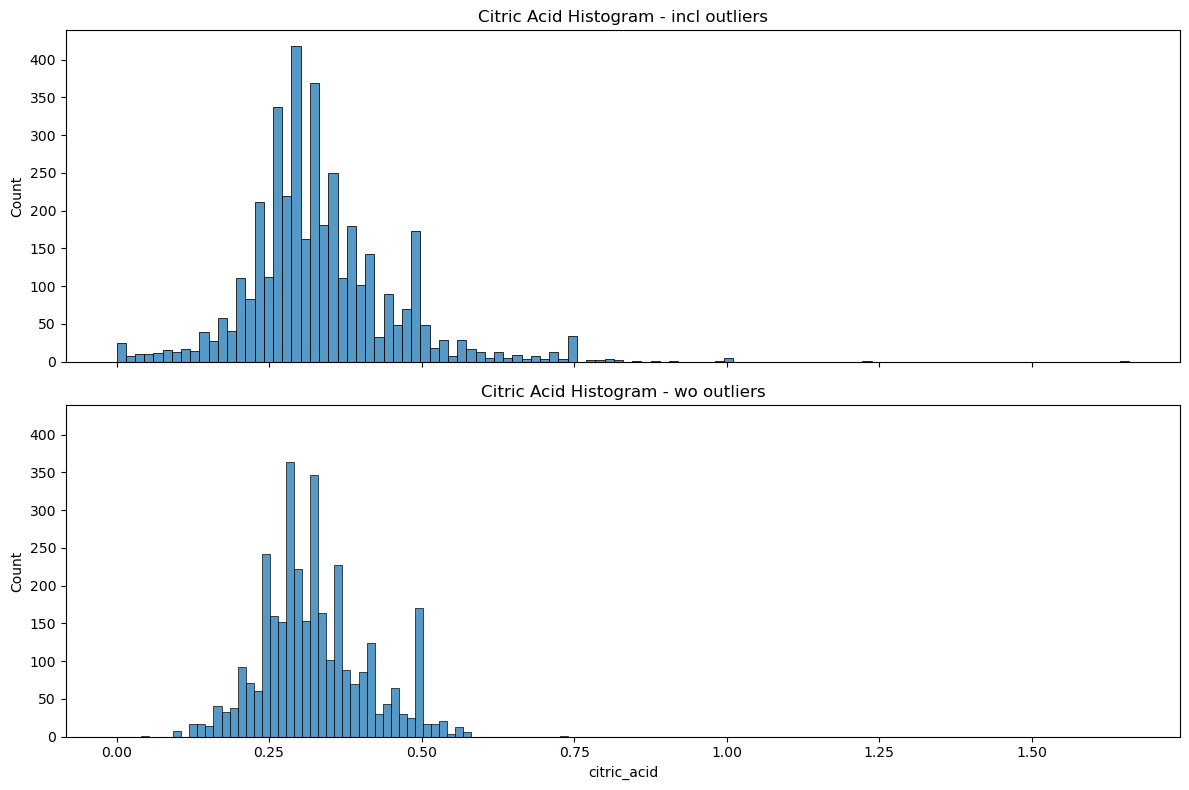

In [72]:
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True, sharey=True)
sns.histplot(wine_w, x='citric_acid', ax=ax[0])
sns.histplot(wine_w[mask_w_wo_outliers], x='citric_acid', ax=ax[1])
ax[0].set_title('Citric Acid Histogram - incl outliers')
ax[1].set_title('Citric Acid Histogram - wo outliers')
plt.tight_layout()

In [73]:
print_normality_report(wine_w.citric_acid)

normally distributed 	 False
skew 			 1.3106010172583804
kurtosis 		 6.844808170477563


In [74]:
print_normality_report(wine_w[mask_w_wo_outliers].citric_acid)

normally distributed 	 False
skew 			 0.4357262343816795
kurtosis 		 0.14671386899514927


## pH

Text(0.5, 1.0, 'pH Histogram')

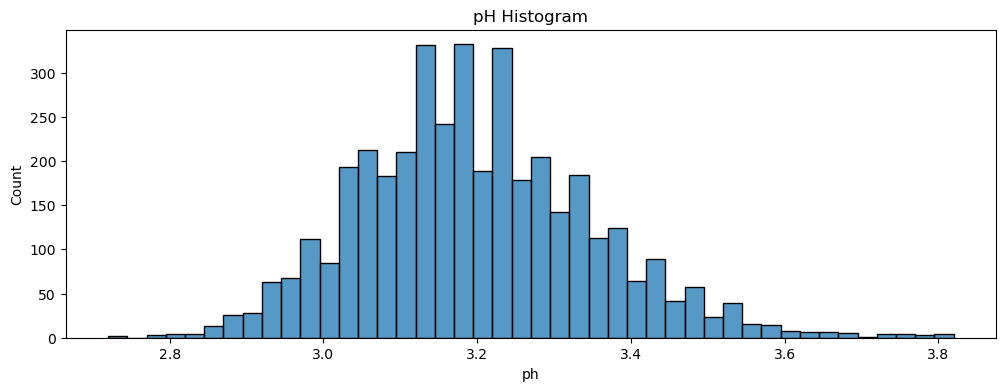

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(12,4), sharex=True)
sns.histplot(wine_w, x='ph', ax=ax)
ax.set_title('pH Histogram')

In [76]:
print_normality_report(wine_w.ph)

normally distributed 	 False
skew 			 0.45545683102180484
kurtosis 		 0.5499570349177985


## Chlorides

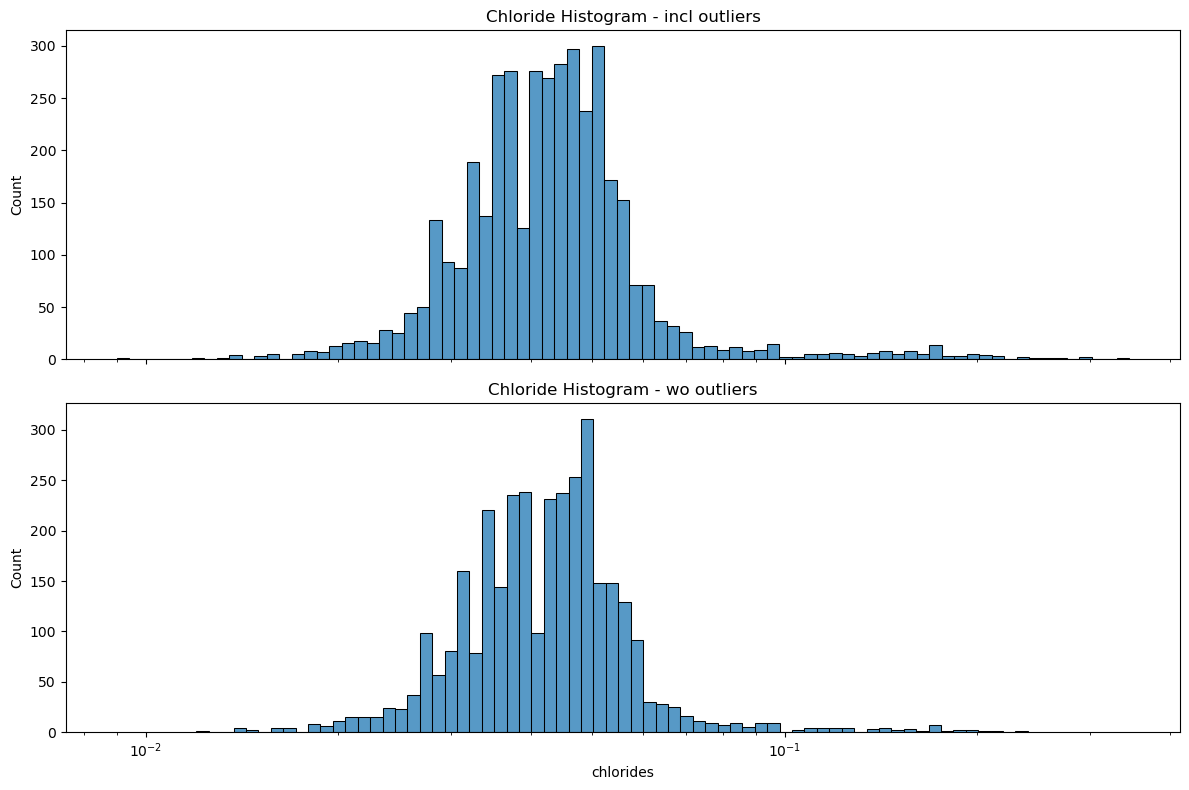

In [77]:
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)#, sharey=True)

sns.histplot(wine_w, x='chlorides', log_scale=True, ax=ax[0])
sns.histplot(wine_w[mask_w_wo_outliers], x='chlorides', log_scale=True, ax=ax[1])

ax[0].set_title('Chloride Histogram - incl outliers')
ax[1].set_title('Chloride Histogram - wo outliers')

plt.tight_layout()

In [78]:
print_normality_report(wine_w.chlorides)

normally distributed 	 False
skew 			 4.9690763179339195
kurtosis 		 35.530287983648144


In [79]:
print_normality_report(wine_w.chlorides.apply(lambda x: np.log(x) if x>0 else None))

normally distributed 	 False
skew 			 1.2217138553725622
kurtosis 		 5.380291883281817


## Total Sulfur Dioxide

Text(0.5, 1.0, 'Total Sulfur Dioxide Histogram')

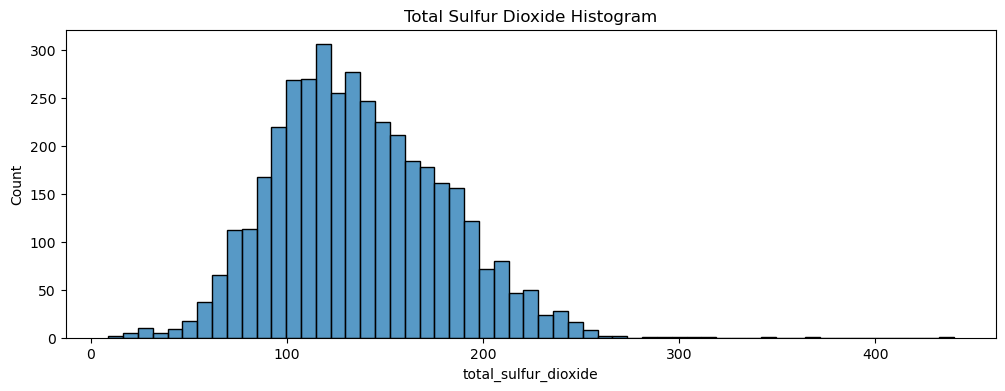

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))#, sharey=True)
sns.histplot(wine_w, x='total_sulfur_dioxide', ax=ax)
ax.set_title('Total Sulfur Dioxide Histogram')

In [81]:
print_normality_report(wine_w.total_sulfur_dioxide)

normally distributed 	 False
skew 			 0.4567996770589028
kurtosis 		 0.7352578602399502


In [82]:
print_normality_report(wine_w[mask_w_wo_outliers].total_sulfur_dioxide)

normally distributed 	 False
skew 			 0.3497594468581323
kurtosis 		 -0.317990381276966


## Free Sulfur Dioxide

Text(0.5, 1.0, 'Free Sulfur Dioxide Histogram')

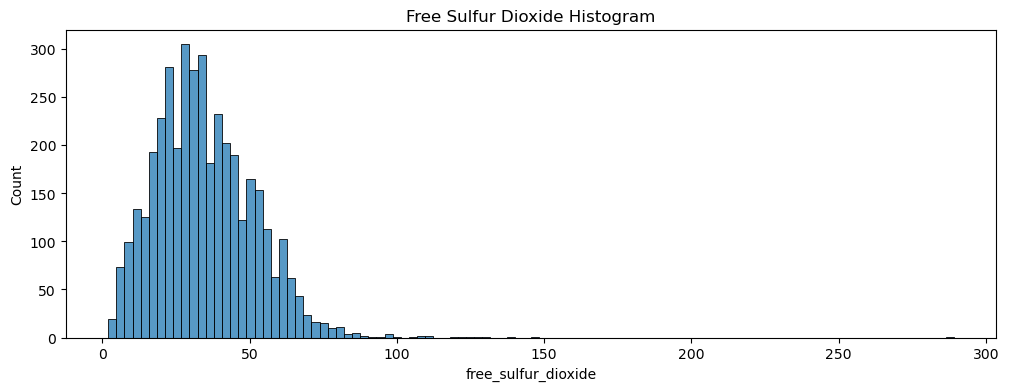

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))#, sharey=True)
sns.histplot(wine_w, x='free_sulfur_dioxide', ax=ax)
ax.set_title('Free Sulfur Dioxide Histogram')

In [84]:
print_normality_report(wine_w.free_sulfur_dioxide)

normally distributed 	 False
skew 			 1.5666802198269172
kurtosis 		 13.434024873683851


## Sulphates

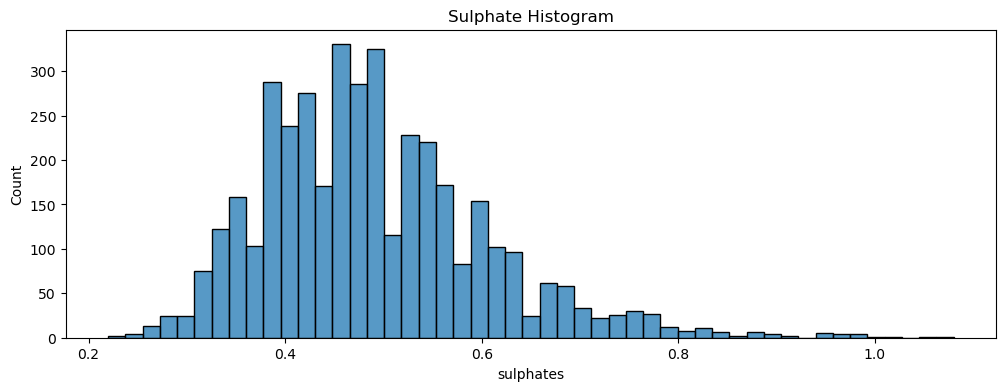

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))#, sharey=True)
sns.histplot(wine_w, x='sulphates', ax=ax)
ax.set_title('Sulphate Histogram')
plt.show()

In [86]:
print_normality_report(wine_w.sulphates)

normally distributed 	 False
skew 			 0.937853335745201
kurtosis 		 1.5650206023903892


## Density

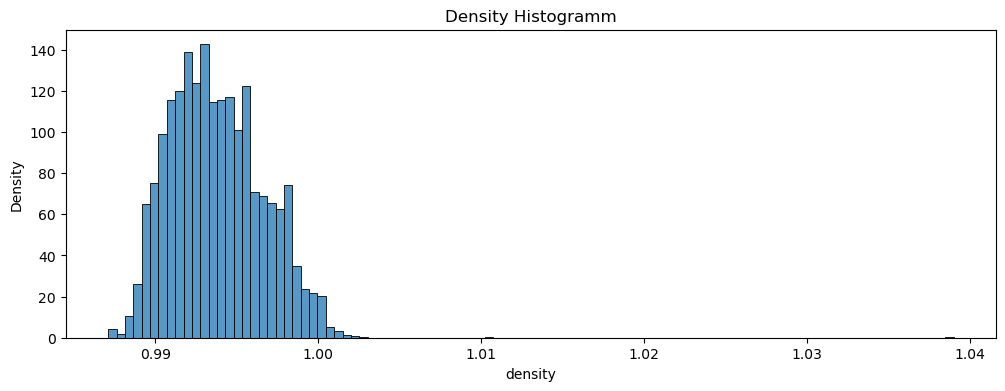

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))#, sharey=True)
sns.histplot(wine_w, x='density', stat='density', ax=ax) # Why is the plot not normalized? Bin width is smaller than 1
ax.set_title('Density Histogramm')
plt.show()

In [88]:
print_normality_report(wine_w.density)

normally distributed 	 False
skew 			 1.273317860741664
kurtosis 		 14.184892106605444


In [89]:
# show high density wines
wine_w[['density', 'residual_sugar', 'alcohol', 'input_outlier_count', 'quality']].sort_values(by='density', ascending=False).head()

,density,residual_sugar,alcohol,input_outlier_count,quality
2781,1.03898,65.80,11.7,2,6
1653,1.01030,31.60,8.8,0,6
3619,1.00295,26.05,10.6,0,6
2334,1.00241,17.80,8.9,1,5
1608,1.00240,23.50,8.6,0,5


Density Outlier is reasonable: high residual sugar leads to high density, while having relatively low alcohol content.

## Residual Sugar

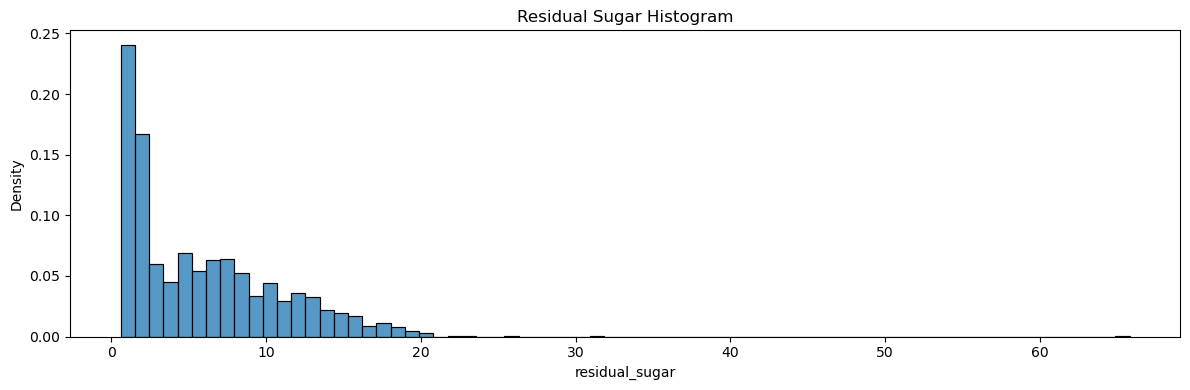

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
sns.histplot(wine_w, x='residual_sugar', stat='density', ax=ax)
ax.set_title('Residual Sugar Histogram')
plt.tight_layout()

In [91]:
print_normality_report(wine_w.residual_sugar)

normally distributed 	 False
skew 			 1.333639018039196
kurtosis 		 5.681512165840735


In [92]:
print_normality_report(wine_w[mask_w_wo_outliers].residual_sugar)

normally distributed 	 False
skew 			 0.9163530822073074
kurtosis 		 0.004176592627427311


## Alcohol

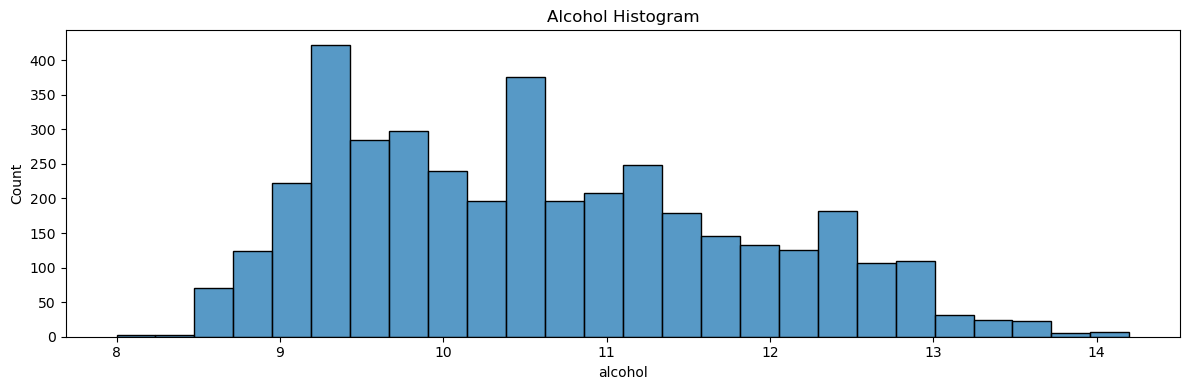

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
sns.histplot(wine_w, x='alcohol', ax=ax)
ax.set_title('Alcohol Histogram')
plt.tight_layout()

In [94]:
print_normality_report(wine_w.alcohol)

normally distributed 	 False
skew 			 0.4506965980443857
kurtosis 		 -0.6959797180212637


# New Features

## Acidity Ratio

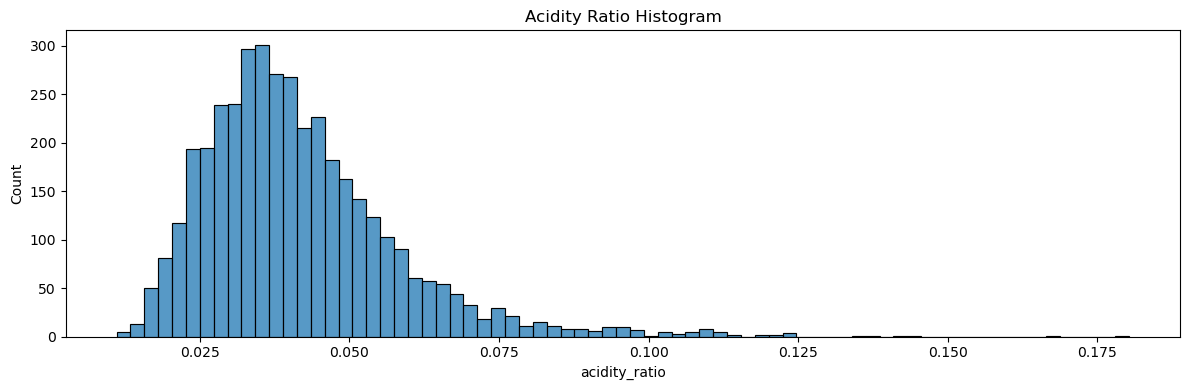

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
sns.histplot(wine_w, x='acidity_ratio', ax=ax)
ax.set_title('Acidity Ratio Histogram')
plt.tight_layout()

## Sulfur Dioxide Ratio

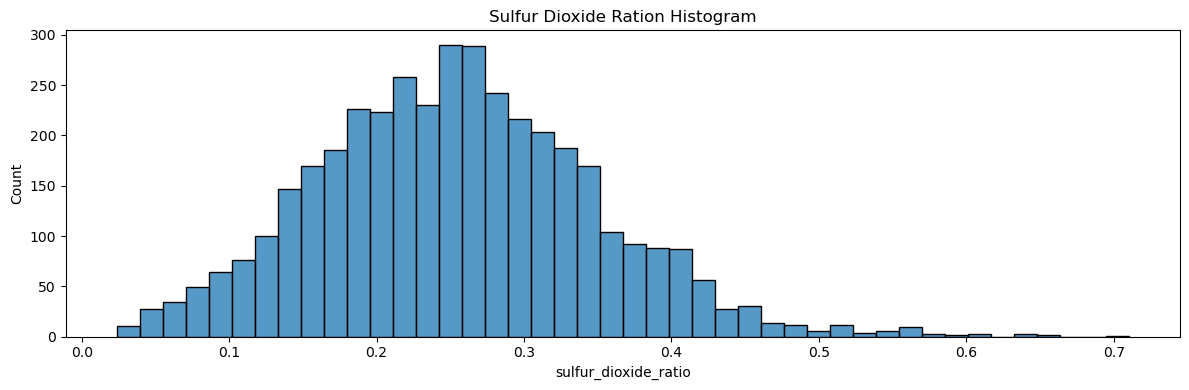

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
sns.histplot(wine_w, x='sulfur_dioxide_ratio', ax=ax)
ax.set_title('Sulfur Dioxide Ration Histogram')
plt.tight_layout()

In [97]:
print_normality_report(wine_w.sulfur_dioxide_ratio)

normally distributed 	 False
skew 			 0.3975475446662062
kurtosis 		 0.5410675191751282


In [98]:
print_normality_report(wine_w[mask_w_wo_outliers].sulfur_dioxide_ratio)

normally distributed 	 False
skew 			 0.21910005903950186
kurtosis 		 0.14763091408454532


# Input vs Input

## Density vs. Sulphates

<Axes: xlabel='sulphates', ylabel='density'>

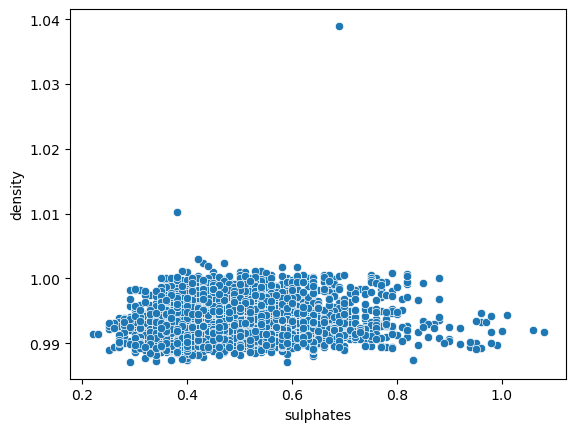

In [99]:
sns.scatterplot(wine_w, y='density', x='sulphates')

## Density vs. Residual Sugar

(0.99, 1.005)

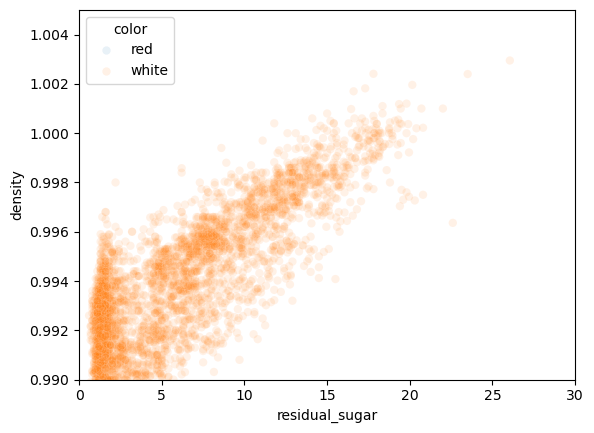

In [100]:
ax = sns.scatterplot(wine_w, y='density', x='residual_sugar', 
                     hue='color', alpha=0.1
                     )

ax.set_xlim([0, 30])
ax.set_ylim([0.99, 1.005])

(0.98, 1.005)

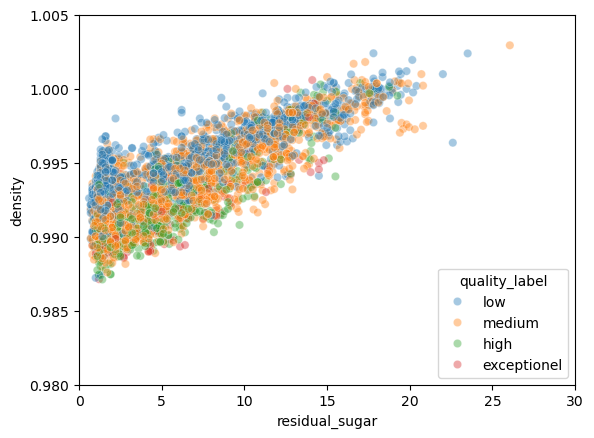

In [101]:
ax = sns.scatterplot(wine_w, y='density', x='residual_sugar', hue='quality_label', alpha=0.4)

ax.set_xlim([0, 30])
ax.set_ylim([0.98, 1.005])

<Axes: xlabel='total_sulfur_dioxide', ylabel='density'>

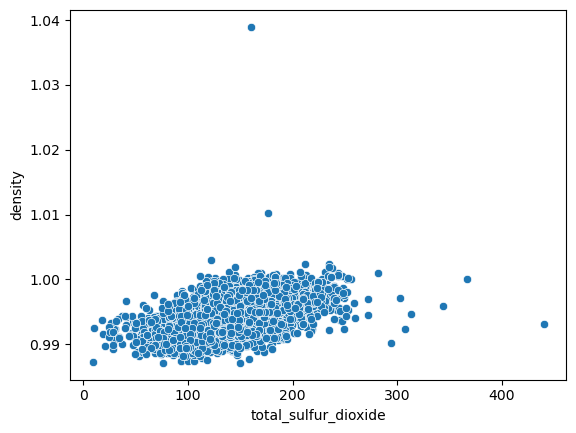

In [102]:
sns.scatterplot(wine_w, y='density', x='total_sulfur_dioxide')

<Axes: xlabel='total_sulfur_dioxide', ylabel='residual_sugar'>

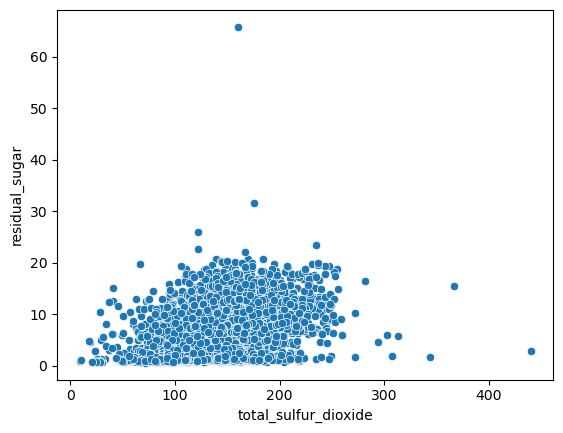

In [103]:
sns.scatterplot(wine_w, y='residual_sugar', x='total_sulfur_dioxide')